## Preprocessing data

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
import warnings
from sklearn.decomposition import FactorAnalysis
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
warnings.filterwarnings("ignore")

df1_16 = pd.read_csv('Patch/Feature 1/all_features_df_scale_16.csv')
df2_16 = pd.read_csv('Patch/Feature 2/all_features_df_scale_16.csv')
df3_16 = pd.read_csv('Patch/Feature 3/all_features_df_scale_16.csv')

df1_32 = pd.read_csv('Patch/Feature 1/all_features_df_scale_32.csv')
df2_32 = pd.read_csv('Patch/Feature 2/all_features_df_scale_32.csv')
df3_32 = pd.read_csv('Patch/Feature 3/all_features_df_scale_32.csv')

df1_64 = pd.read_csv('Patch/Feature 1/all_features_df_scale_64.csv')
df2_64 = pd.read_csv('Patch/Feature 2/all_features_df_scale_64.csv')
df3_64 = pd.read_csv('Patch/Feature 3/all_features_df_scale_64.csv')

pathomic_feature_16 = pd.concat([df1_16, df2_16, df3_16], ignore_index=True)
## Drop the caracteres after CHUM or IUCPQ
pathomic_feature_16['wsi_name'] = pathomic_feature_16['wsi_name'].str.replace(r'(?<=CHUM).*', '', regex=True)
pathomic_feature_16['wsi_name'] = pathomic_feature_16['wsi_name'].str.replace(r'(?<=IUCPQ).*', '', regex=True)
# Remplacez " IUCPQ" par "-IUCPQ"
pathomic_feature_16['wsi_name'] = pathomic_feature_16['wsi_name'].str.replace(' IUCPQ', '-IUCPQ')
pathomic_feature_16.set_index(pathomic_feature_16.columns[0], inplace=True)


pathomic_feature_32 = pd.concat([df1_32, df2_32, df3_32], ignore_index=True)
pathomic_feature_32['wsi_name'] = pathomic_feature_32['wsi_name'].str.replace(r'(?<=CHUM).*', '', regex=True)
pathomic_feature_32['wsi_name'] = pathomic_feature_32['wsi_name'].str.replace(r'(?<=IUCPQ).*', '', regex=True)
pathomic_feature_32['wsi_name'] = pathomic_feature_32['wsi_name'].str.replace(' IUCPQ', '-IUCPQ')
pathomic_feature_32.set_index(pathomic_feature_32.columns[0], inplace=True)


pathomic_feature_64 = pd.concat([df1_64, df2_64, df3_64], ignore_index=True)
pathomic_feature_64['wsi_name'] = pathomic_feature_64['wsi_name'].str.replace(r'(?<=CHUM).*', '', regex=True)
pathomic_feature_64['wsi_name'] = pathomic_feature_64['wsi_name'].str.replace(r'(?<=IUCPQ).*', '', regex=True)
pathomic_feature_64['wsi_name'] = pathomic_feature_64['wsi_name'].str.replace(' IUCPQ', '-IUCPQ')
pathomic_feature_64.set_index(pathomic_feature_64.columns[0], inplace=True)

pyrad_CHUM = pd.read_csv('projects/def-veman3/radiomics_imagia/PyRads_CHUM.csv')
pyrad_IUCPQ = pd.read_csv('projects/def-veman3/radiomics_imagia/PyRads_IUCPQ.csv')
radiomic_feature = pd.concat([pyrad_CHUM, pyrad_IUCPQ], ignore_index=True)
radiomic_feature.drop('Unnamed: 0', axis=1, inplace=True)
radiomic_feature.rename(columns={'oncotech_id': 'wsi_name'}, inplace=True)
radiomic_feature.set_index(radiomic_feature.columns[0], inplace=True)

## Feature normalisation to ensure that all extracted descriptors were within the same range of values by subtracting the mean and dividing 
## by the standard deviation
norm_pathomic_feature_16 = (pathomic_feature_16 - pathomic_feature_16.mean()) / pathomic_feature_16.std()
norm_pathomic_feature_32 = (pathomic_feature_32 - pathomic_feature_32.mean()) / pathomic_feature_32.std()
norm_pathomic_feature_64 = (pathomic_feature_64 - pathomic_feature_64.mean()) / pathomic_feature_64.std()
norm_radiomic_feature = (radiomic_feature - radiomic_feature.mean()) / radiomic_feature.std()

# scaler = StandardScaler()
# norm_pathomic_feature_16 = scaler.fit_transform(pathomic_feature_16)
# norm_pathomic_feature_32 = scaler.fit_transform(pathomic_feature_32)
# norm_pathomic_feature_64 = scaler.fit_transform(pathomic_feature_64)

In [4]:
## Compter le nombre de fois qu'on a le mot CHUM
count = pathomic_feature_64.index[pathomic_feature_64.index.to_series().str.contains('IUCPQ')].shape[0]
print(count)

26


In [3]:
###  reduce feature redundancy
### a correlation filter based on the absolute values of pairwise Spearman’s correlation (r) coefficient was used to reduce feature redundancy. Threshold
## for r was set to 0.9. Briefly, if two features had r > 0.9, the function looks at the mean absolute correlation of each variable
## and the variable with the largest mean absolute correlation is removed.


def remove_highly_correlated(df, threshold=0.9):
    """
    Supprime les caractéristiques hautement corrélées basées sur le coefficient de corrélation de Spearman.
    """
    # Calculer la matrice de corrélation de Spearman
    corr_matrix = df.corr(method='spearman').abs()
    
    # Trouver les paires de caractéristiques hautement corrélées
    high_corr_var = set()
    for i in range(corr_matrix.shape[0]):
        for j in range(i+1, corr_matrix.shape[1]):
            if corr_matrix.iloc[i, j] > threshold:
                colname_i = corr_matrix.columns[i]
                colname_j = corr_matrix.columns[j]
                mean_abs_corr_i = corr_matrix[colname_i].mean()
                mean_abs_corr_j = corr_matrix[colname_j].mean()
                if mean_abs_corr_i > mean_abs_corr_j:
                    high_corr_var.add(colname_i)
                else:
                    high_corr_var.add(colname_j)
    
    # Supprimer les caractéristiques hautement corrélées
    df_reduced = df.drop(columns=high_corr_var)
    return df_reduced

In [4]:
radiomic_feature.shape

(387, 851)

In [4]:
pathomic_feature_16_reduce = remove_highly_correlated(norm_pathomic_feature_16)

pathomic_feature_32_reduce = remove_highly_correlated(norm_pathomic_feature_32)

pathomic_feature_64_reduce = remove_highly_correlated(norm_pathomic_feature_64)

radiomic_feature_reduce = remove_highly_correlated(norm_radiomic_feature)

In [5]:
radiopathomic_feature_64 = pathomic_feature_64_reduce.join(radiomic_feature_reduce, how = 'inner')
##radiopathomic_feature_64.to_csv('radiopathomic_feature_64.csv', index=False)

In [33]:
radiomic_feature.shape

(37, 155)

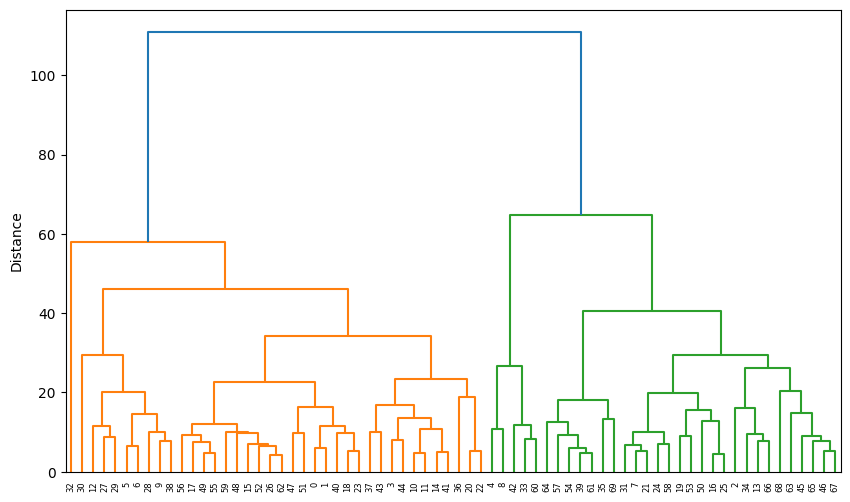

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

# Générer des données aléatoires pour l'exemple
pathomic_feature = radiopathomic_feature_64.iloc[:, :42]
radiomic_feature =  radiopathomic_feature_64.iloc[:, 44:]
data = norm_pathomic_feature_16
# Calculer la matrice de distance entre les données
#dist_matrix = pdist(data)
# Calculer les liaisons (linkages) pour la classification hiérarchique
linkages = linkage(data, method='ward')  # Vous pouvez choisir une autre méthode si nécessaire

plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(linkages, orientation='top')
plt.ylabel('Distance')
plt.savefig('dendo_radiomic.png', dpi=600, bbox_inches='tight')
plt.show()

In [13]:

n_clusters = 2  # Spécifiez le nombre de classes souhaité
df = radiomic_feature
cluster = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels = cluster.fit_predict(df)

# Ajouter les étiquettes de cluster au DataFrame
df['Cluster_Labels'] = cluster_labels

In [17]:
df['Cluster_Labels'].value_counts()

1    28
0     9
Name: Cluster_Labels, dtype: int64

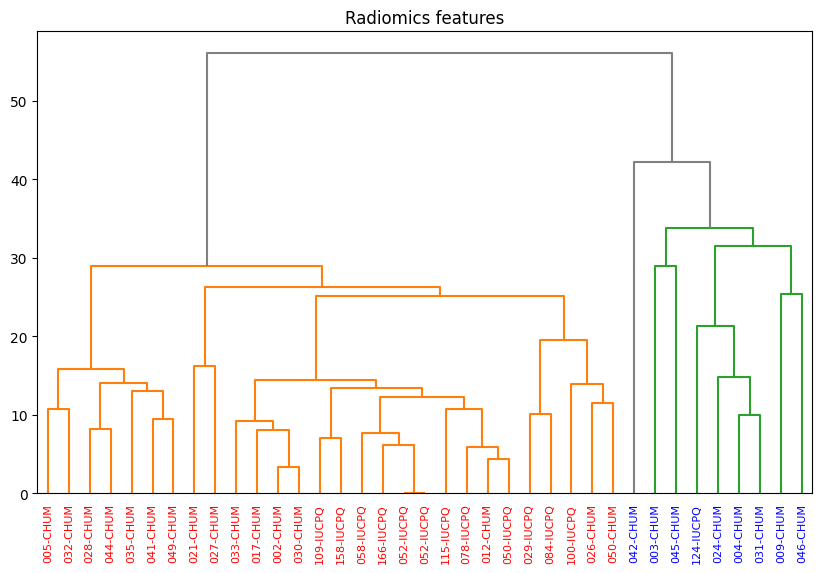

In [92]:
# Libraries
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import matplotlib.colors as mcolors

pathomic_feature = radiopathomic_feature_64.iloc[:, :42]
radiomic_feature =  radiopathomic_feature_64.iloc[:, 44:]
df = radiomic_feature
 
# Calculate the distance between each sample
Z = linkage(df, 'ward')
 
# Make the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=df.index, leaf_rotation=90,leaf_font_size=8, color_threshold=34, orientation="top", above_threshold_color='grey')
plt.title('Radiomics features')
# Create a color palette with 3 colors for the 2 cyl possibilities
##my_palette = plt.cm.get_cmap("Accent", 2)
 
# Définir les couleurs
colors = ['blue', 'red']

# Créer la palette de couleurs
my_palette = mcolors.ListedColormap(colors)
    
# n_clusters = 2  # Spécifiez le nombre de classes souhaité
# df = radiomic_feature
# cluster = AgglomerativeClustering(n_clusters=n_clusters)
# cluster_labels = cluster.fit_predict(df)
# # Ajouter les étiquettes de cluster au DataFrame
# df['Cluster_Labels'] = cluster_labels
# df['Cluster_Labels']=pd.Categorical(df['Cluster_Labels'])
# my_color=df['Cluster_Labels'].cat.codes


dfcolor = pd.read_csv('color2.csv')
dfcolor['code']=pd.Categorical(dfcolor['code'])
my_color=dfcolor['code'].cat.codes

# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    val=my_color[num]
    lbl.set_color(my_palette(val))
# # Créer une légende personnalisée pour les couleurs PFS

# legend_labels = {
#     'Cluster 0': plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#666666ff', markersize=10),
#     'Cluster 1': plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#666666ff', markersize=10)
# }

# Afficher la légende dans le coin supérieur droit
##plt.legend(legend_labels.values(), legend_labels.keys(), loc='upper right')
#plt.axhline(y=20, c='grey', lw=1, linestyle='dashed')
# Show the graph
plt.savefig('dendo_radiomicNew.png', dpi=600, bbox_inches='tight')
plt.show()

In [57]:
##df['Cluster_Labels'].head()
#my_color.to_csv('my_color.csv', index=False)

dfcolor = pd.read_csv('color2.csv')
dfcolor['code']=pd.Categorical(dfcolor['code'])
my_color=dfcolor['code'].cat.codes

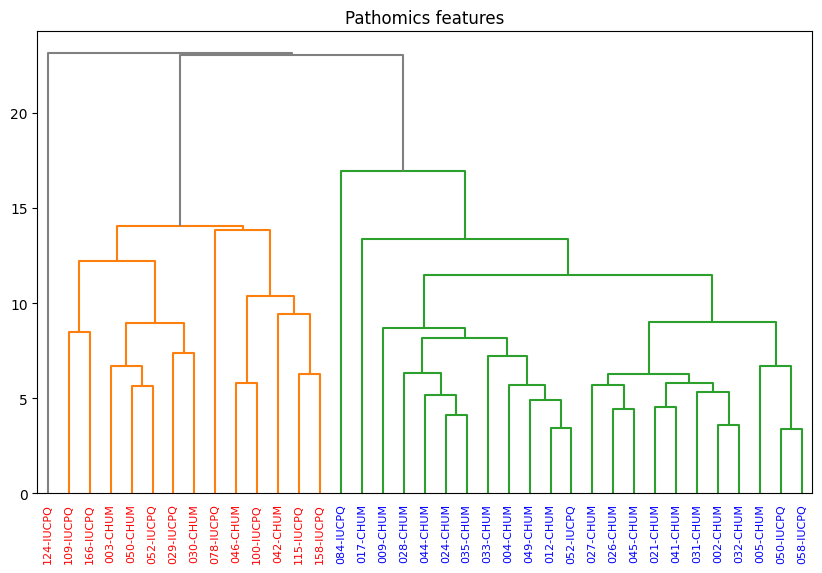

In [91]:
# Libraries
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
pathomic_feature = radiopathomic_feature_64.iloc[:, :42]
radiomic_feature =  radiopathomic_feature_64.iloc[:, 44:]
df = pathomic_feature
 
# Calculate the distance between each sample
Z = linkage(df, 'ward')
 
# Make the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=df.index, leaf_rotation=90,leaf_font_size=8, color_threshold=20, orientation="top", above_threshold_color='grey')
plt.title('Pathomics features')
# Create a color palette with 3 colors for the 2 cyl possibilities
#my_palette = plt.cm.get_cmap("Accent", 2)

# Définir les couleurs
colors = ['blue', 'red']

# Créer la palette de couleurs
my_palette = mcolors.ListedColormap(colors)


# n_clusters = 2  # Spécifiez le nombre de classes souhaité
# df = pathomic_feature
# cluster = AgglomerativeClustering(n_clusters=n_clusters)
# cluster_labels = cluster.fit_predict(df)
# # Ajouter les étiquettes de cluster au DataFrame
# df['Cluster_Labels'] = cluster_labels
# df['Cluster_Labels']=pd.Categorical(df['Cluster_Labels'])
# my_color=df['Cluster_Labels'].cat.codes



dfcolor = pd.read_csv('color3.csv')
dfcolor['code']=pd.Categorical(dfcolor['code'])
my_color=dfcolor['code'].cat.codes


# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    val=my_color[num]
    lbl.set_color(my_palette(val))
# # Créer une légende personnalisée pour les couleurs PFS

# legend_labels = {
#     'Patients in the same cluster in A': plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=10),
#     'Patients in the same cluster in A': plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10),
# }

# Afficher la légende dans le coin supérieur droit
# plt.legend(legend_labels.values(), legend_labels.keys(), loc='upper right')
# plt.axhline(y=11, c='grey', lw=1, linestyle='dashed')
# Show the graph
plt.savefig('dendo_pathomicNEW.png', dpi=600, bbox_inches='tight')
plt.show()

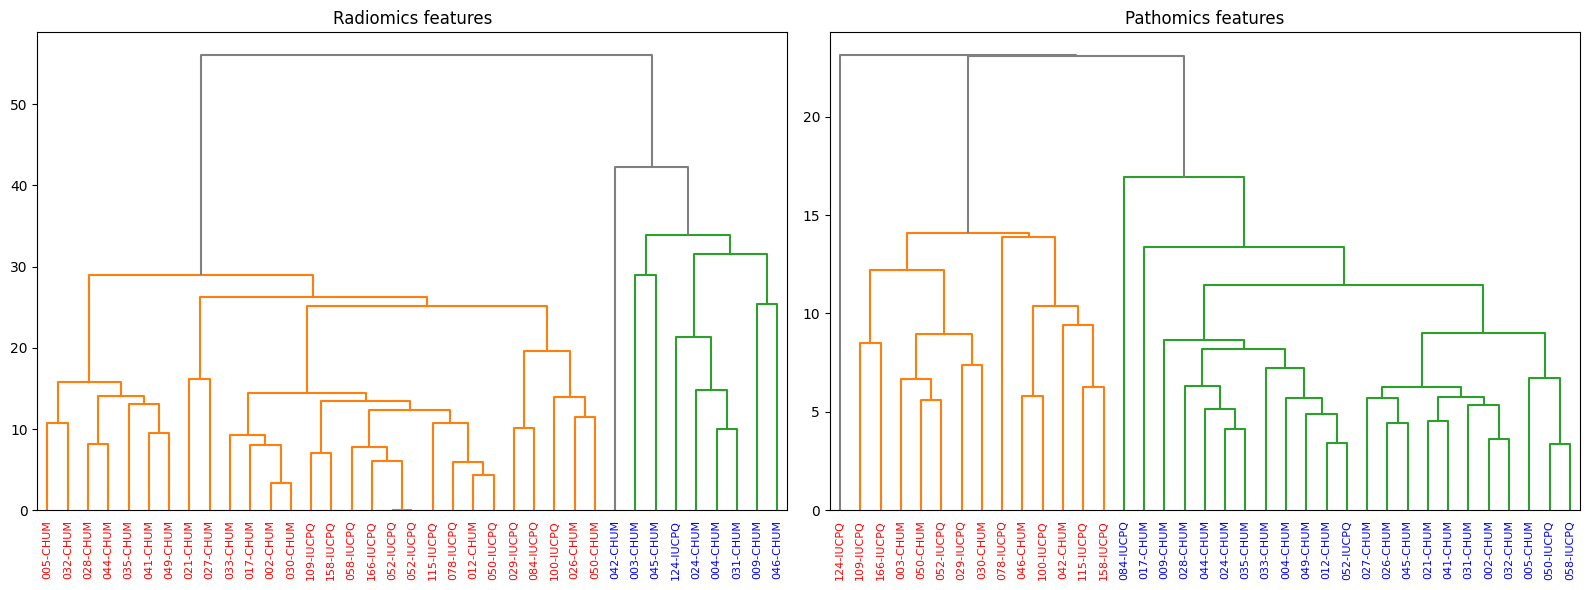

In [8]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import matplotlib.colors as mcolors

# Charger vos données pathomiques et radiomiques
pathomic_feature = radiopathomic_feature_64.iloc[:, :42]
radiomic_feature = radiopathomic_feature_64.iloc[:, 44:]

# Créer une figure avec deux sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Premier sous-graphique pour les radiomiques
df = radiomic_feature
Z = linkage(df, 'ward')
dendrogram(Z, labels=df.index, leaf_rotation=90, leaf_font_size=8, color_threshold=34, orientation="top", above_threshold_color='grey', ax=axes[0])
axes[0].set_title('Radiomics features')

# Définir les couleurs
colors = ['blue', 'red']
my_palette = mcolors.ListedColormap(colors)

dfcolor = pd.read_csv('color2.csv')
dfcolor['code'] = pd.Categorical(dfcolor['code'])
my_color = dfcolor['code'].cat.codes

# Appliquer la bonne couleur à chaque étiquette
xlbls = axes[0].get_xmajorticklabels()
num = -1
for lbl in xlbls:
    num += 1
    val = my_color[num]
    lbl.set_color(my_palette(val))

# Deuxième sous-graphique pour les pathomiques
df = pathomic_feature
Z = linkage(df, 'ward')
dendrogram(Z, labels=df.index, leaf_rotation=90, leaf_font_size=8, color_threshold=20, orientation="top", above_threshold_color='grey', ax=axes[1])
axes[1].set_title('Pathomics features')

dfcolor = pd.read_csv('color3.csv')
dfcolor['code'] = pd.Categorical(dfcolor['code'])
my_color = dfcolor['code'].cat.codes

# Appliquer la bonne couleur à chaque étiquette
xlbls = axes[1].get_xmajorticklabels()
num = -1
for lbl in xlbls:
    num += 1
    val = my_color[num]
    lbl.set_color(my_palette(val))

plt.tight_layout()
plt.savefig('dendo_patho_radio.png', dpi=600, bbox_inches='tight')
plt.show()


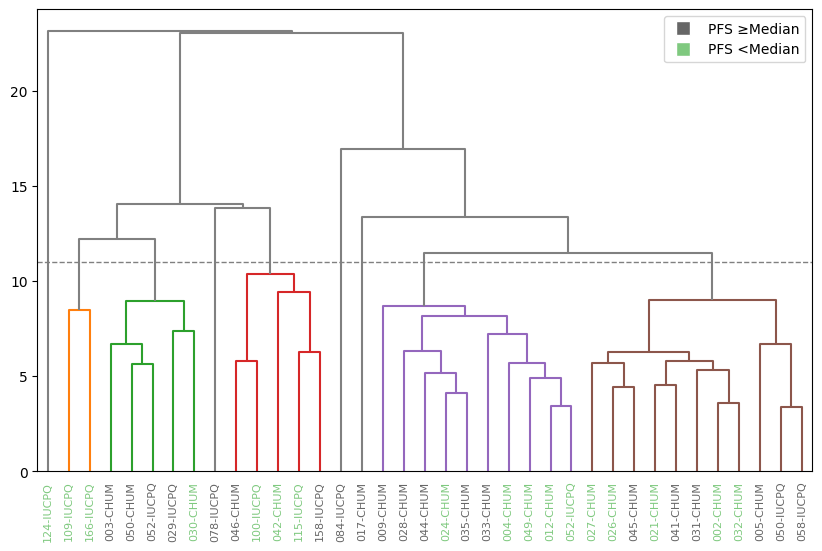

In [11]:
# Libraries
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
pathomic_feature = radiopathomic_feature_64.iloc[:, :42]
radiomic_feature =  radiopathomic_feature_64.iloc[:, 44:]
df = pathomic_feature
 
# Calculate the distance between each sample
Z = linkage(df, 'ward')
 
# Make the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=df.index, leaf_rotation=90,leaf_font_size=8, color_threshold=11, orientation="top", above_threshold_color='grey')
 
# Create a color palette with 3 colors for the 2 cyl possibilities
my_palette = plt.cm.get_cmap("Accent", 2)
 
 
df = df.join(subset_CHUM_IUCPQ, how = 'inner')

df['PFS'] = ['PFS≥Median' if x >= 253 else 'PFS<Median'  for x in df['pfs_days']]
df['PFS']=pd.Categorical(df['PFS'])
my_color=df['PFS'].cat.codes

# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    val=my_color[num]
    lbl.set_color(my_palette(val))
# # Créer une légende personnalisée pour les couleurs PFS

legend_labels = {
    'PFS ≥Median': plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#666666ff', markersize=10),
    'PFS <Median': plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#7fc97fff', markersize=10)
}

# Afficher la légende dans le coin supérieur droit
plt.legend(legend_labels.values(), legend_labels.keys(), loc='upper right')
plt.axhline(y=11, c='grey', lw=1, linestyle='dashed')
# Show the graph
plt.savefig('dendo_pathomicPFSV2.png', dpi=600, bbox_inches='tight')
plt.show()

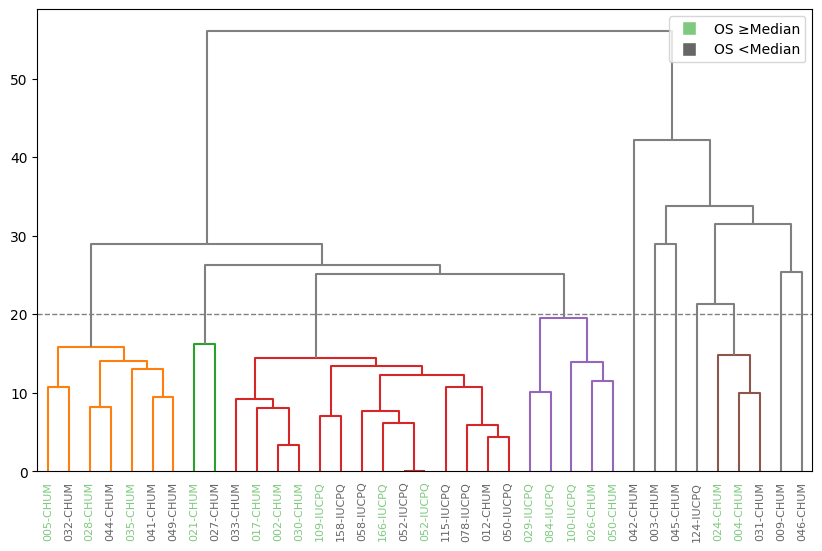

In [12]:
# Libraries
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
pathomic_feature = radiopathomic_feature_64.iloc[:, :42]
radiomic_feature =  radiopathomic_feature_64.iloc[:, 44:]
df = radiomic_feature
 
# Calculate the distance between each sample
Z = linkage(df, 'ward')
 
# Make the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=df.index, leaf_rotation=90,leaf_font_size=8, color_threshold=20, orientation="top", above_threshold_color='grey')
 
# Create a color palette with 3 colors for the 2 cyl possibilities
my_palette = plt.cm.get_cmap("Accent", 2)
 
 
df = df.join(subset_CHUM_IUCPQ, how = 'inner')

df['OS'] = ['OS≥Median' if x >= 651 else 'OS<Median'  for x in df['os_days']]
df['OS']=pd.Categorical(df['OS'])
my_color=df['OS'].cat.codes

# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    val=my_color[num]
    lbl.set_color(my_palette(val))
# # Créer une légende personnalisée pour les couleurs PFS

legend_labels = {
    'OS ≥Median': plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#7fc97fff', markersize=10),
    'OS <Median': plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#666666ff', markersize=10)
}

# Afficher la légende dans le coin supérieur droit
plt.legend(legend_labels.values(), legend_labels.keys(), loc='upper right')
plt.axhline(y=20, c='grey', lw=1, linestyle='dashed')
# Show the graph
plt.savefig('dendo_radiomicOSV2.png', dpi=600, bbox_inches='tight')
plt.show()

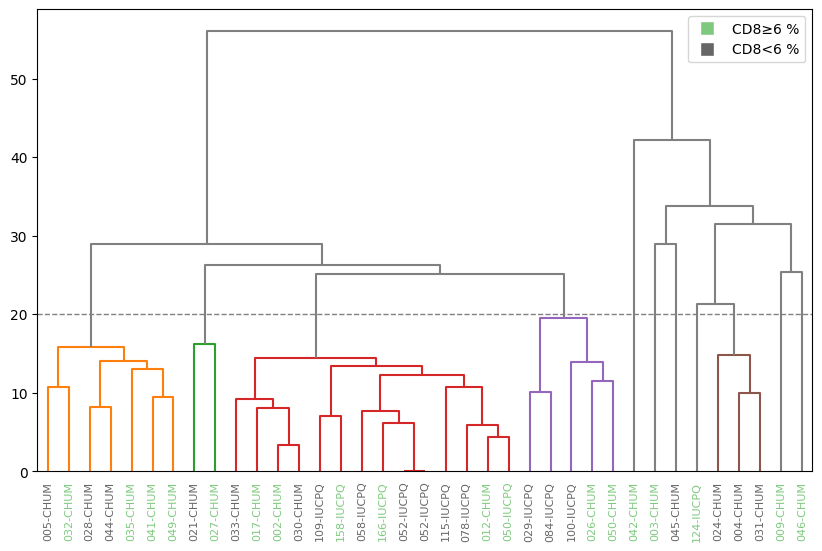

In [50]:
# Libraries
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
pathomic_feature = radiopathomic_feature_64.iloc[:, :42]
radiomic_feature =  radiopathomic_feature_64.iloc[:, 44:]
df = radiomic_feature
 
# Calculate the distance between each sample
Z = linkage(df, 'ward')
 
# Make the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=df.index, leaf_rotation=90,leaf_font_size=8, color_threshold=20, orientation="top", above_threshold_color='grey')
 
# Create a color palette with 3 colors for the 2 cyl possibilities
my_palette = plt.cm.get_cmap("Accent", 2)
 
 
df = df.join(subset_CHUM_IUCPQ, how = 'inner')
cd8 = df['CD8_PercTumor']
# Calculez les quantiles (par exemple, médiane)
median_quantile = cd8.quantile(0.5)

# Choisissez un seuil (par exemple, médiane) pour diviser en deux classes
seuil = median_quantile

# Appliquez la division en fonction du seuil
df['CD8'] = np.where(cd8 >= seuil, 'CD8≥6 %', 'CD8<6 %')
df['CD8']=pd.Categorical(df['CD8'])
my_color=df['CD8'].cat.codes

# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    val=my_color[num]
    lbl.set_color(my_palette(val))
# # Créer une légende personnalisée pour les couleurs PFS

legend_labels = {
    'CD8≥6 %': plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#7fc97fff', markersize=10),
    'CD8<6 %': plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#666666ff', markersize=10)
}

# Afficher la légende dans le coin supérieur droit
plt.legend(legend_labels.values(), legend_labels.keys(), loc='upper right')
plt.axhline(y=20, c='grey', lw=1, linestyle='dashed')
# Show the graph
plt.savefig('dendo_radiomicCD8V2.png', dpi=600, bbox_inches='tight')
plt.show()

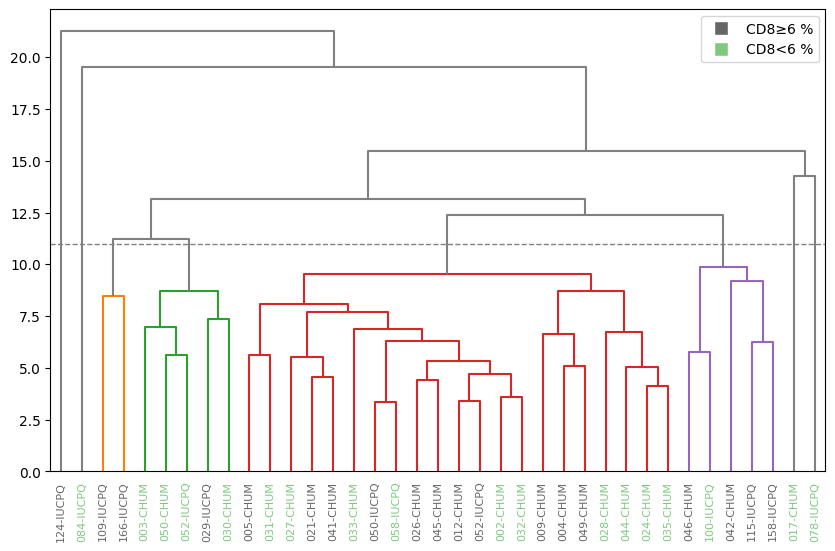

In [37]:
# Libraries
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
pathomic_feature = radiopathomic_feature_64.iloc[:, :42]
radiomic_feature =  radiopathomic_feature_64.iloc[:, 44:]
df = pathomic_feature
 
# Calculate the distance between each sample
Z = linkage(df, 'complete')
 
# Make the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=df.index, leaf_rotation=90,leaf_font_size=8, color_threshold=11, orientation="top", above_threshold_color='grey')
 
# Create a color palette with 3 colors for the 2 cyl possibilities
my_palette = plt.cm.get_cmap("Accent", 2)
 
 
df = df.join(subset_CHUM_IUCPQ, how = 'inner')

cd8 = df['CD8_PercTumor']
# Calculez les quantiles (par exemple, médiane)
median_quantile = cd8.quantile(0.5)

# Choisissez un seuil (par exemple, médiane) pour diviser en deux classes
seuil = median_quantile

# Appliquez la division en fonction du seuil
df['CD8'] = np.where(cd8 >= seuil, 'CD8≥6 %', 'CD8<6 %')
df['CD8']=pd.Categorical(df['CD8'])
my_color=df['CD8'].cat.codes

# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    val=my_color[num]
    lbl.set_color(my_palette(val))
# # Créer une légende personnalisée pour les couleurs PFS

legend_labels = {
    'CD8≥6 %': plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#666666ff', markersize=10),
    'CD8<6 %': plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#7fc97fff', markersize=10)
}

# Afficher la légende dans le coin supérieur droit
plt.legend(legend_labels.values(), legend_labels.keys(), loc='upper right')
plt.axhline(y=11, c='grey', lw=1, linestyle='dashed')
# Show the graph
plt.savefig('dendo_pathomicCD8V2.png', dpi=600, bbox_inches='tight')
plt.show()

In [41]:


import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt


pathomic_feature = radiopathomic_feature_64.iloc[:, :42]
radiomic_feature =  radiopathomic_feature_64.iloc[:, 44:]

df = pathomic_feature
df2 = radiomic_feature

# Effectuer la classification hiérarchique
n_clusters = 2  # Spécifiez le nombre de classes souhaité
cluster = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels = cluster.fit_predict(df)
df['Cluster_Labels'] = cluster_labels
col = ['Cluster_Labels']
df_selection = df.loc[:, col]

# Effectuer la classification hiérarchique
n_clusters = 2  # Spécifiez le nombre de classes souhaité
cluster = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels = cluster.fit_predict(df2)
df2['Cluster_Labels2'] = cluster_labels
col = ['Cluster_Labels2']
df_selection2 = df2.loc[:, col]

dfcombine = df_selection.join(df_selection2, how = 'inner')
dfcombine = dfcombine.join(subset_CHUM_IUCPQ, how = 'inner')
dfcombine.reset_index(inplace=True)
dfcombine.to_csv('dfcombine.csv', index=False)

In [6]:
# pathomic_feature_16_reduce.to_csv('pathomic_feature_16.csv', index=False)
# # save the dataframe in the patch folder
# pathomic_feature_32_reduce.to_csv('pathomic_feature_32.csv', index=False)
# # save the dataframe in the patch folder
# pathomic_feature_64_reduce.to_csv('pathomic_feature_64.csv', index=False)
radiomic_feature_reduce.to_csv('radiomic_feature.csv', index=False)

In [7]:
# Dictionnaire pour stocker les nouveaux noms de colonnes
new_columns = {}

# Itérer sur les noms de colonnes existants
for col in radiomic_feature_reduce.columns:
    if 'wavelet' in col:
        new_columns[col] = "Filter-based features"
    elif any(substring in col for substring in ['glrlm','glcm','gldm', 'glszm', 'gldzm', 'ngtdm']):
        new_columns[col] = "Texture-based features"
    elif 'shape' in col:
        new_columns[col] = "Shape-based features"
    elif 'firstorder' in col:
        new_columns[col] = "Intensity-based features"

# Renommer les colonnes en utilisant le dictionnaire
radiomic_feature_reduce.rename(columns=new_columns, inplace=True)

radiomic_feature_reduce.to_csv('radiomic_feature_with_group.csv', index=False)
# Affichage du DataFrame mis à jour
radiomic_feature_reduce.head()


,Shape-based features,Shape-based features,Shape-based features,Shape-based features,Shape-based features,Intensity-based features,Intensity-based features,Intensity-based features,Intensity-based features,Intensity-based features,...,Filter-based features,Filter-based features,Filter-based features,Filter-based features,Filter-based features,Filter-based features,Filter-based features,Filter-based features,Filter-based features,Filter-based features
wsi_name,,,,,,,,,,,,,,,,,,,,,
002-CHUM,-0.919252,-0.995302,0.811502,0.257184,-0.768948,0.032597,0.601619,0.197924,0.692996,-0.728376,...,0.400519,-0.194100,-0.783452,0.140418,-0.230042,0.389262,-0.484583,0.373338,-0.455363,-0.269116
003-CHUM,-1.814176,-1.324096,-1.057408,-0.343002,4.409948,0.621849,-4.794118,-5.666332,-0.444583,0.231874,...,-0.425177,-0.190135,1.813643,-1.245608,4.607282,-0.713249,3.903143,-3.201946,-0.790876,2.920184
004-CHUM,-0.802936,-1.250648,-0.801558,-0.322447,1.482906,0.317729,-2.014449,-2.130671,0.371506,1.014551,...,-0.462449,-0.194470,1.186744,-1.035125,0.362175,-0.574511,0.823638,-1.012816,-0.749881,0.039460
005-CHUM,-0.127929,-1.584771,0.165415,-0.947776,0.938667,-0.140370,-0.277684,-0.115724,0.579945,-0.101542,...,0.044974,-0.195038,0.713897,-0.296756,-0.179690,0.358244,-0.092243,-0.542485,-0.625867,-0.345531
006-CHUM,1.095860,-0.407342,-0.626847,0.659983,-0.490960,0.153507,0.667633,0.635129,0.968559,0.564415,...,-0.696636,-0.194986,-0.599954,-0.480968,-0.179694,-0.558788,-0.397155,-0.851703,-0.644647,-0.320293


In [9]:
pathomic_feature_16_reduce.shape

(70, 17)

In [10]:
pathomic_feature_32_reduce.shape

(70, 30)

In [38]:
subset_CHUM_IUCPQ.head()

,CD8_PercTumor,pfs_days,os_days,histology_group
wsi_name,,,,
025-IUCPQ,2.95365,5,72,Squamous
026-IUCPQ,3.53000,54,405,Adenocarcinoma
027-IUCPQ,4.45000,629,902,Squamous
028-IUCPQ,11.36000,1206,1206,Adenocarcinoma
029-IUCPQ,8.73000,78,161,Other


In [12]:
radiomic_feature_reduce.shape

(387, 156)

In [70]:
radiomic_feature_reduce.to_csv('Patch/radiomic_feature_reduce.csv', index=False)

In [11]:
# Remplacer les colonnes du deuxième DataFrame par le premier
# et mettre des NA comme valeur pour les colonnes qui n'ont pas de correspondances
pathomic_feature_32_reduce = pathomic_feature_32_reduce.reindex(columns=pathomic_feature_64_reduce.columns)

In [23]:
df2 = pd.read_excel('projects/def-veman3/ul-val-prj-criucpq-poc/Oncotech-WSI/Clinical_data/clinical_IHC_iucpq_chum_mai2023.xlsx', sheet_name = 'IHC')
df_cd8 = df[['oncotech_id', 'CD8_PercTumor']]
subset_CHUM_IUCPQ.head()

,oncotech_id,CD8_PercTumor
0,025-IUCPQ,2.95365
1,026-IUCPQ,3.53000
2,027-IUCPQ,4.45000
3,028-IUCPQ,11.36000
4,029-IUCPQ,8.73000


In [6]:
df = pd.read_excel('projects/def-veman3/ul-val-prj-criucpq-poc/Oncotech-WSI/Clinical_data/clinical_IHC_iucpq_chum_mai2023.xlsx')
subset_CHUM_IUCPQ = df[['oncotech_id', 'pfs_days', 'os_days','histology_group']]
subset_CHUM_IUCPQ.rename(columns={'oncotech_id': 'wsi_name'}, inplace=True)
subset_CHUM_IUCPQ.set_index(subset_CHUM_IUCPQ.columns[0], inplace=True)
pathomic_feature_16_pfs_os = pathomic_feature_16_reduce.join(subset_CHUM_IUCPQ, how = 'inner')
pathomic_feature_16_pfs_os.shape

(56, 20)

In [43]:
subset_CHUM_IUCPQ

,CD8_PercTumor,pfs_days,os_days,histology_group
wsi_name,,,,
025-IUCPQ,2.95365,5,72,Squamous
026-IUCPQ,3.53000,54,405,Adenocarcinoma
027-IUCPQ,4.45000,629,902,Squamous
028-IUCPQ,11.36000,1206,1206,Adenocarcinoma
029-IUCPQ,8.73000,78,161,Other
...,...,...,...,...
289-CHUM,8.00000,427,427,Adenocarcinoma
293-CHUM,15.69000,83,166,Adenocarcinoma
296-CHUM,1.06000,138,153,Adenocarcinoma


In [7]:
## Compter le nombre de fois qu'on a le mot CHUM
count = pathomic_feature_16_pfs_os.index[pathomic_feature_16_pfs_os.index.to_series().str.contains('CHUM')].shape[0]
print(count)

30


In [6]:
df = pd.read_excel('projects/def-veman3/ul-val-prj-criucpq-poc/Oncotech-WSI/Clinical_data/clinical_IHC_iucpq_chum_mai2023.xlsx')
subset_CHUM_IUCPQ = df[['oncotech_id', 'pfs_days', 'os_days','histology_group']]
subset_CHUM_IUCPQ.rename(columns={'oncotech_id': 'wsi_name'}, inplace=True)
subset_CHUM_IUCPQ.set_index(subset_CHUM_IUCPQ.columns[0], inplace=True)

df2 = pd.read_excel('projects/def-veman3/ul-val-prj-criucpq-poc/Oncotech-WSI/Clinical_data/clinical_IHC_iucpq_chum_mai2023.xlsx', sheet_name = 'IHC')
df_cd8 = df2[['oncotech_id', 'CD8_PercTumor']]
df_cd8.rename(columns={'oncotech_id': 'wsi_name'}, inplace=True)
df_cd8.set_index(df_cd8.columns[0], inplace=True)

# # Merge pathomic and pfs/os data
subset_CHUM_IUCPQ = df_cd8.join(subset_CHUM_IUCPQ, how = 'inner')
pathomic_feature_16_pfs_os = pathomic_feature_16_reduce.join(subset_CHUM_IUCPQ, how = 'inner')
pathomic_feature_32_pfs_os = pathomic_feature_32_reduce.join(subset_CHUM_IUCPQ, how = 'inner')
pathomic_feature_64_pfs_os = pathomic_feature_64_reduce.join(subset_CHUM_IUCPQ, how = 'inner')

# Merge radiomic feature and pfs/os data
radiomic_feature_pfs_os = radiomic_feature_reduce.join(subset_CHUM_IUCPQ, how = 'inner')

## Merge radiomic, pathomic feature and pfs/os data
radio_pathomic_pfs_os_cd8_feature_16 = pathomic_feature_16_pfs_os.join(radiomic_feature_reduce, how = 'inner')
radio_pathomic_pfs_os_cd8_feature_32 = pathomic_feature_32_pfs_os.join(radiomic_feature_reduce, how = 'inner')
radio_pathomic_pfs_os_cd8_feature_64 = pathomic_feature_64_pfs_os.join(radiomic_feature_reduce, how = 'inner')

# # save the dataframe in the patch folder
# pathomic_feature_16.to_csv('Patch/Merge feature/pathomic_feature_16.csv', index=False)
# # save the dataframe in the patch folder
# pathomic_feature_32.to_csv('Patch/Merge feature/pathomic_feature_32.csv', index=False)
# # save the dataframe in the patch folder
# pathomic_feature_64.to_csv('Patch/Merge feature/pathomic_feature_64.csv', index=False)
# radiomic_feature.to_csv('Patch/Merge feature/radiomic_feature.csv', index=False)
# pathomic_feature_16_pfs_os.to_csv('Patch/Reduce feature/pathomic_feature_16_pfs_os.csv', index=False)
# pathomic_feature_32_pfs_os.to_csv('Patch/Reduce feature/pathomic_feature_32_pfs_os.csv', index=False)
# pathomic_feature_64_pfs_os.to_csv('Patch/Reduce feature/pathomic_feature_64_pfs_os.csv', index=False)
# radiomic_feature_pfs_os.to_csv('Patch/Reduce feature/radiomic_feature_pfs_os.csv', index=False)

# radio_pathomic_pfs_os_feature_16.to_csv('Patch/Reduce feature/radio_pathomic_pfs_os_feature_16.csv', index=False)
# radio_pathomic_pfs_os_feature_32.to_csv('Patch/Reduce feature/radio_pathomic_pfs_os_feature_32.csv', index=False)
# radio_pathomic_pfs_os_feature_64.to_csv('Patch/Reduce feature/radio_pathomic_pfs_os_feature_64.csv', index=False)

In [9]:
subset_CHUM_IUCPQ.shape

(119, 4)

In [15]:
radio_pathomic_pfs_os_cd8_feature_16.reset_index(inplace=True)
radio_pathomic_pfs_os_cd8_feature_16.rename(columns={radio_pathomic_pfs_os_cd8_feature_16.columns[0]: 'oncotech_id'}, inplace=True)

radio_pathomic_pfs_os_cd8_feature_32.reset_index(inplace=True)
radio_pathomic_pfs_os_cd8_feature_32.rename(columns={radio_pathomic_pfs_os_cd8_feature_32.columns[0]: 'oncotech_id'}, inplace=True)

radio_pathomic_pfs_os_cd8_feature_64.reset_index(inplace=True)
radio_pathomic_pfs_os_cd8_feature_64.rename(columns={radio_pathomic_pfs_os_cd8_feature_64.columns[0]: 'oncotech_id'}, inplace=True)

radio_pathomic_pfs_os_cd8_feature_16.to_csv('Patch/radio_pathomic_pfs_os_cd8_feature_16.csv', index=False)
radio_pathomic_pfs_os_cd8_feature_32.to_csv('Patch/radio_pathomic_pfs_os_cd8_feature_32.csv', index=False)
radio_pathomic_pfs_os_cd8_feature_64.to_csv('Patch/radio_pathomic_pfs_os_cd8_feature_64.csv', index=False)

In [20]:
radio_pathomic_pfs_os_cd8_feature_16.head()

,median_contrast_D1,median_IMC1_D1,median_sum_variance_D2,median_sum_average_D3,var_correlation_D1,var_sum_average_D1,var_IMC2_D1,var_sum_variance_D2,kurtosis_correlation_D1,kurtosis_sum_average_D1,...,wavelet.LLL_glszm_GrayLevelVariance,wavelet.LLL_glszm_LargeAreaLowGrayLevelEmphasis,wavelet.LLL_glszm_SizeZoneNonUniformityNormalized,wavelet.LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet.LLL_glrlm_LongRunLowGrayLevelEmphasis,wavelet.LLL_ngtdm_Complexity,wavelet.LLL_ngtdm_Contrast,wavelet.LLL_gldm_DependenceEntropy,wavelet.LLL_gldm_LargeDependenceHighGrayLevelEmphasis,wavelet.LLL_gldm_LargeDependenceLowGrayLevelEmphasis
wsi_name,,,,,,,,,,,,,,,,,,,,,
002-CHUM,0.299298,0.936611,-0.407165,-0.394007,-0.265271,-0.638173,-0.687584,-1.053030,-0.679471,-0.202798,...,0.400519,-0.194100,-0.783452,0.140418,-0.230042,0.389262,-0.484583,0.373338,-0.455363,-0.269116
003-CHUM,0.057102,-0.482915,1.163060,-0.099724,-0.914648,-1.141070,-0.698276,-0.948704,-0.431150,-0.216699,...,-0.425177,-0.190135,1.813643,-1.245608,4.607282,-0.713249,3.903143,-3.201946,-0.790876,2.920184
004-CHUM,0.436403,0.548457,-0.155458,-0.019690,-1.085018,-0.903339,-0.695904,-0.907504,-0.369100,-0.014641,...,-0.462449,-0.194470,1.186744,-1.035125,0.362175,-0.574511,0.823638,-1.012816,-0.749881,0.039460
005-CHUM,0.752062,0.876768,-0.393210,-1.236800,-1.480979,-0.286370,-0.698606,-1.356945,0.717986,-0.480509,...,0.044974,-0.195038,0.713897,-0.296756,-0.179690,0.358244,-0.092243,-0.542485,-0.625867,-0.345531
009-CHUM,0.027584,0.198953,0.018503,0.412229,-1.129980,-1.132176,-0.696498,-0.897462,-0.127988,-0.172986,...,-0.425976,-0.193712,2.397383,-0.929039,1.319440,-0.612118,4.278649,-2.202630,-0.773505,0.468239


In [9]:
##radio_pathomic_pfs_os_feature_16.shape
## Compter le nombre de fois qu'on a le mot CHUM
count = radio_pathomic_pfs_os_feature_16.index[radio_pathomic_pfs_os_feature_16.index.to_series().str.contains('IUCPQ')].shape[0]
print(count)

13


In [16]:
radio_pathomic_pfs_os_feature_16.to_csv('radio_pathomic_pfs_os_feature_16.csv', index=False)
radio_pathomic_pfs_os_feature_32.to_csv('radio_pathomic_pfs_os_feature_32.csv', index=False)
radio_pathomic_pfs_os_feature_64.to_csv('radio_pathomic_pfs_os_feature_64.csv', index=False)

### Correlation within pathomic feature and radiomic feature at scale 16 x 16

In [44]:
# Calculate Spearman’s rank correlation coefficient and p-value for each pair of radiomic and pathomic features
## the correlation coefficient and the associated p-values were computed for each pair of radiomic and pathomic features using Spearman’s rank 
## correlation test (to ensure robustness to outliers while quantifying monotonicity )
correlations = {}
p_values = []
pvalues = {}
significant_correlations = {}  # Pour stocker les corrélations significatives

pathomic_feature = radio_pathomic_pfs_os_cd8_feature_16.iloc[:, :17]
pfs_os = radio_pathomic_pfs_os_cd8_feature_16.iloc[:, 17:21]
radiomic_feature =  radio_pathomic_pfs_os_cd8_feature_16.iloc[:, 21:]

# Iterate through each possible pair of features
for radio_feature in [col for col in radiomic_feature.columns]:
    for patho_feature in [col for col in pathomic_feature.columns]:
        coeff, p = spearmanr(radiomic_feature[radio_feature], pathomic_feature[patho_feature])
        correlations[(radio_feature, patho_feature)] = coeff
        pvalues[(radio_feature, patho_feature)] = p
        p_values.append(p)
        if abs(coeff) > 0.44:  # Nous vérifions la valeur absolue car la corrélation peut être négative
            significant_correlations[(radio_feature, patho_feature)] = coeff
           

# Sorting the correlations dictionary by absolute correlation values
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

# Take top 20 pairs
top_20_correlated_pairs = sorted_correlations[:40]

# Convertir le dictionnaire en DataFrame
df_correlations_16 = pd.DataFrame(list(correlations.items()), columns=['Features_Pair', 'Correlation'])

# Si vous souhaitez diviser les paires de fonctionnalités en deux colonnes distinctes :
df_correlations_16['Radio_Feature'] = df_correlations_16['Features_Pair'].apply(lambda x: x[0])
df_correlations_16['Patho_Feature'] = df_correlations_16['Features_Pair'].apply(lambda x: x[1])
df_correlations_16 = df_correlations_16.drop('Features_Pair', axis=1)

# Réorganiser les colonnes pour une meilleure lisibilité
df_correlations_16 = df_correlations_16[['Radio_Feature', 'Patho_Feature', 'Correlation']]
            
# Afficher les corrélations significatives
for (radio, patho), coeff in significant_correlations.items():
    print(f"Correlation within {radio} and {patho} : {coeff:.3f}")

Correlation within original_ngtdm_Busyness and median_sum_variance_D2 : -0.604
Correlation within wavelet.LLH_glcm_Imc1 and median_sum_variance_D2 : -0.480
Correlation within wavelet.LHL_glcm_Imc2 and median_sum_variance_D2 : 0.444
Correlation within wavelet.LHH_firstorder_Mean and var_IMC2_D1 : 0.521
Correlation within wavelet.LHH_firstorder_Mean and skewness_sum_variance_D2 : -0.454
Correlation within wavelet.HLH_glcm_Imc1 and median_sum_variance_D2 : -0.444
Correlation within wavelet.HLH_gldm_DependenceEntropy and var_sum_average_D1 : 0.586
Correlation within wavelet.HLH_gldm_DependenceEntropy and kurtosis_IMC2_D3 : -0.551
Correlation within wavelet.HHL_gldm_DependenceEntropy and var_sum_average_D1 : 0.454


In [45]:
df_correlations_16.to_csv('df_correlations_16.csv', index=False)

In [7]:
df_top_20 = pd.DataFrame(top_20_correlated_pairs, columns=['Variable_Pair', 'Correlation'])

# Splitting the tuple of 'Variable_Pair' into two separate columns
df_top_20['Radio_Feature'] = df_top_20['Variable_Pair'].apply(lambda x: x[0])
df_top_20['Patho_Feature'] = df_top_20['Variable_Pair'].apply(lambda x: x[1])
df_top_20 = df_top_20.drop(columns=['Variable_Pair'])

In [7]:
# Étape 1: Créez une matrice vide
all_radio_features = radiomic_feature.columns
all_patho_features = pathomic_feature.columns
corr_matrix = pd.DataFrame(data=0, index=all_radio_features, columns=all_patho_features)

# Étape 2: Remplissez la matrice avec vos corrélations significatives
for (radio, patho), coeff in correlations.items():
    corr_matrix.at[radio, patho] = coeff

# Supprimer les lignes qui ont des corrélations nulles
non_zero_rows = corr_matrix.sum(axis=1) != 0
corr_matrix = corr_matrix[non_zero_rows]

# Supprimer les colonnes qui ont des corrélations nulles
non_zero_cols = corr_matrix.sum(axis=0) != 0
corr_matrix = corr_matrix.loc[:, non_zero_cols]
    
# Les noms des variables à sélectionner
feature_names = df_correlations_16['Patho_Feature'].tolist()
corr_matrix = corr_matrix[feature_names]
# Les index à sélectionner
index_names = df_correlations_16['Radio_Feature'].tolist()
# Sélectionnez les lignes de la nouvelle base de données en fonction des observations de Radio_Feature
corr_matrix = corr_matrix.loc[index_names]
# Supprimer les doublons dans l'index tout en conservant la première occurrence
corr_matrix = corr_matrix[~corr_matrix.index.duplicated(keep='first')]
corr_matrix = corr_matrix.T.drop_duplicates().T
corr_matrix_16 = corr_matrix
# # Étape 3: Visualisez la heatmap
# plt.figure(figsize=(12, 9))
# sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, cbar=True, vmin=-1, vmax=1)
# ##plt.title("Heatmap of Significant Correlations")
# plt.savefig('heatmaps_V2_64.png', dpi=300, bbox_inches='tight')
# plt.show()

In [27]:
corr_matrix.to_csv('corr_matrix.csv', index=False)

### False Discovery Rate Correction

In [23]:
# dentifying significant correlations using False Discovery Rate (FDR) correction for multiple hypotheses testing,
## with statistical significance when FDR ≤ 0.01. 
rejected, corrected_p_values, _, _ = multipletests(p_values, alpha=0.01, method='fdr_bh')
# Use a flag to determine if significant correlations were found
found_significant = False

# Display significant correlations
for idx, (pair, coeff) in enumerate(correlations.items()):
    if rejected[idx] and corrected_p_values[idx] <= 0.01:
        print(f"Significant correlation between {pair[0]} and {pair[1]} with coefficient: {coeff:.3f} and corrected p-value: {corrected_p_values[idx]:.5f}")
        found_significant = True

# If no significant correlations were found, print the respective message
if not found_significant:
    print("No Significant correlation")

No Significant correlation


In [24]:
corrected_p_values

array([0.9991439, 0.9991439, 0.9991439, ..., 0.9991439, 0.9991439,
       0.9991439])

### Correlation within pathomic feature and radiomic feature at scale 32 x 32

In [50]:

correlations = {}
p_values = []
significant_correlations = {}  # Pour stocker les corrélations significatives

pathomic_feature = radio_pathomic_pfs_os_cd8_feature_32.iloc[:, :30]
pfs_os = radio_pathomic_pfs_os_cd8_feature_32.iloc[:, 30:34]
radiomic_feature =  radio_pathomic_pfs_os_cd8_feature_32.iloc[:, 34:]

# Iterate through each possible pair of pathomic and radiomic features
for radio_feature in radiomic_feature.columns:
    for patho_feature in pathomic_feature.columns:
        coeff, p = spearmanr(radiomic_feature[radio_feature], pathomic_feature[patho_feature])
        correlations[(radio_feature, patho_feature)] = coeff
        p_values.append(p)
        if abs(coeff) > 0.46:  # Nous vérifions la valeur absolue car la corrélation peut être négative
            significant_correlations[(radio_feature, patho_feature)] = coeff

# Convertir le dictionnaire en DataFrame
df_significant_correlations_32 = pd.DataFrame(list(correlations.items()), columns=['Features_Pair', 'Correlation'])

# Si vous souhaitez diviser les paires de fonctionnalités en deux colonnes distinctes :
df_significant_correlations_32['Radio_Feature'] = df_significant_correlations_32['Features_Pair'].apply(lambda x: x[0])
df_significant_correlations_32['Patho_Feature'] = df_significant_correlations_32['Features_Pair'].apply(lambda x: x[1])
df_significant_correlations_32 = df_significant_correlations_32.drop('Features_Pair', axis=1)

# Réorganiser les colonnes pour une meilleure lisibilité
df_significant_correlations_32 = df_significant_correlations_32[['Radio_Feature', 'Patho_Feature', 'Correlation']]            

# Afficher les corrélations significatives
for (radio, patho), coeff in significant_correlations.items():
    print(f"Correlation within {radio} and {patho} : {coeff:.3f}")

Correlation within original_glcm_JointEntropy and skewness_difference_variance_D1 : -0.461
Correlation within wavelet.LHH_firstorder_Mean and var_IMC2_D3 : 0.496
Correlation within wavelet.LHH_firstorder_Mean and skewness_IMC1_D1 : -0.498
Correlation within wavelet.LHH_firstorder_Mean and skewness_IMC1_D3 : -0.537
Correlation within wavelet.LHH_firstorder_Mean and skewness_contrast_D4 : -0.527
Correlation within wavelet.HLH_gldm_DependenceEntropy and var_sum_average_D1 : 0.578
Correlation within wavelet.HLH_gldm_DependenceEntropy and kurtosis_IMC2_D3 : -0.572
Correlation within wavelet.HLH_gldm_DependenceEntropy and skewness_difference_variance_D1 : -0.491
Correlation within wavelet.HHH_glszm_SizeZoneNonUniformityNormalized and kurtosis_IMC1_D1 : 0.519


In [54]:
df_significant_correlations_32.to_csv('df_significant_correlations_32.csv', index=False)

In [9]:
# Étape 1: Créez une matrice vide
all_radio_features = radiomic_feature.columns
all_patho_features = pathomic_feature.columns
corr_matrix = pd.DataFrame(data=0, index=all_radio_features, columns=all_patho_features)

# Étape 2: Remplissez la matrice avec vos corrélations significatives
for (radio, patho), coeff in correlations.items():
    corr_matrix.at[radio, patho] = coeff

# Supprimer les lignes qui ont des corrélations nulles
non_zero_rows = corr_matrix.sum(axis=1) != 0
corr_matrix = corr_matrix[non_zero_rows]

# Supprimer les colonnes qui ont des corrélations nulles
non_zero_cols = corr_matrix.sum(axis=0) != 0
corr_matrix = corr_matrix.loc[:, non_zero_cols]
    
# Les noms des variables à sélectionner
feature_names = df_significant_correlations_32['Patho_Feature'].tolist()
corr_matrix = corr_matrix[feature_names]
# Les index à sélectionner
index_names = df_significant_correlations_32['Radio_Feature'].tolist()
# Sélectionnez les lignes de la nouvelle base de données en fonction des observations de Radio_Feature
corr_matrix = corr_matrix.loc[index_names]
# Supprimer les doublons dans l'index tout en conservant la première occurrence
corr_matrix = corr_matrix[~corr_matrix.index.duplicated(keep='first')]
corr_matrix = corr_matrix.T.drop_duplicates().T
corr_matrix_32 = corr_matrix
# # Étape 3: Visualisez la heatmap
# plt.figure(figsize=(12, 9))
# sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, cbar=True, vmin=-1, vmax=1)
# ##plt.title("Heatmap of Significant Correlations")
# plt.savefig('heatmaps_V2_64.png', dpi=300, bbox_inches='tight')
# plt.show()

### False Discovery Rate Correction

In [13]:
# Apply FDR correction
rejected, corrected_p_values, _, _ = multipletests(p_values, alpha=0.01, method='fdr_bh')
# Use a flag to determine if significant correlations were found
found_significant = False

# Display significant correlations
for idx, (pair, coeff) in enumerate(correlations.items()):
    if rejected[idx] and corrected_p_values[idx] <= 0.01:
        print(f"Significant correlation between {pair[0]} and {pair[1]} with coefficient: {coeff:.3f} and corrected p-value: {corrected_p_values[idx]:.5f}")
        found_significant = True

# If no significant correlations were found, print the respective message
if not found_significant:
    print("No Significant correlation")

No Significant correlation


### Correlation within pathomic feature and radiomic feature at scale 64 x 64

In [61]:

correlations = {}
p_values = []
significant_correlations = {}  # Pour stocker les corrélations significatives

pathomic_feature = radio_pathomic_pfs_os_cd8_feature_64.iloc[:, :41]
pfs_os = radio_pathomic_pfs_os_cd8_feature_64.iloc[:, 41:44]
radiomic_feature =  radio_pathomic_pfs_os_cd8_feature_64.iloc[:, 45:]


for radio_feature in radiomic_feature.columns:
    for patho_feature in pathomic_feature.columns:
        coeff, p = spearmanr(radiomic_feature[radio_feature], pathomic_feature[patho_feature])
        correlations[(radio_feature, patho_feature)] = coeff
        p_values.append(p)
        if abs(coeff) > 0.47:  # Nous vérifions la valeur absolue car la corrélation peut être négative
            significant_correlations[(radio_feature, patho_feature)] = coeff

# Convertir le dictionnaire en DataFrame
df_significant_correlations_64 = pd.DataFrame(list(correlations.items()), columns=['Features_Pair', 'Correlation'])

# Si vous souhaitez diviser les paires de fonctionnalités en deux colonnes distinctes :
df_significant_correlations_64['Radio_Feature'] = df_significant_correlations_64['Features_Pair'].apply(lambda x: x[0])
df_significant_correlations_64['Patho_Feature'] = df_significant_correlations_64['Features_Pair'].apply(lambda x: x[1])
df_significant_correlations_64 = df_significant_correlations_64.drop('Features_Pair', axis=1)

# Réorganiser les colonnes pour une meilleure lisibilité
df_significant_correlations_64 = df_significant_correlations_64[['Radio_Feature', 'Patho_Feature', 'Correlation']]   
            
# Afficher les corrélations significatives
for (radio, patho), coeff in significant_correlations.items():
    print(f"Correlation within {radio} and {patho} : {coeff:.3f}")

Correlation within original_glszm_SmallAreaEmphasis and skewness_correlation_D3 : -0.502
Correlation within wavelet.LLH_glszm_SmallAreaEmphasis and skewness_correlation_D3 : -0.526
Correlation within wavelet.LHL_firstorder_Mean and kurtosis_IMC1_D3 : 0.480
Correlation within wavelet.LHL_firstorder_Mean and skewness_IMC2_D2 : -0.568
Correlation within wavelet.LHH_firstorder_Mean and mean_IMC2_D2 : -0.480
Correlation within wavelet.HLL_glszm_GrayLevelVariance and kurtosis_IMC1_D3 : -0.644
Correlation within wavelet.HLL_gldm_DependenceEntropy and kurtosis_IMC1_D3 : -0.500
Correlation within wavelet.HLH_gldm_DependenceEntropy and var_sum_average_D1 : 0.578
Correlation within wavelet.LLL_glszm_GrayLevelVariance and skewness_IMC1_D1 : -0.496


In [63]:
df_significant_correlations_64.to_csv('df_significant_correlations_64.csv', index=False)

In [11]:
# Étape 1: Créez une matrice vide
all_radio_features = radiomic_feature.columns
all_patho_features = pathomic_feature.columns
corr_matrix = pd.DataFrame(data=0, index=all_radio_features, columns=all_patho_features)

# Étape 2: Remplissez la matrice avec vos corrélations significatives
for (radio, patho), coeff in correlations.items():
    corr_matrix.at[radio, patho] = coeff

# Supprimer les lignes qui ont des corrélations nulles
non_zero_rows = corr_matrix.sum(axis=1) != 0
corr_matrix = corr_matrix[non_zero_rows]

# Supprimer les colonnes qui ont des corrélations nulles
non_zero_cols = corr_matrix.sum(axis=0) != 0
corr_matrix = corr_matrix.loc[:, non_zero_cols]
    
# Les noms des variables à sélectionner
feature_names = df_significant_correlations_64['Patho_Feature'].tolist()
corr_matrix = corr_matrix[feature_names]
# Les index à sélectionner
index_names = df_significant_correlations_64['Radio_Feature'].tolist()
# Sélectionnez les lignes de la nouvelle base de données en fonction des observations de Radio_Feature
corr_matrix = corr_matrix.loc[index_names]
# Supprimer les doublons dans l'index tout en conservant la première occurrence
corr_matrix = corr_matrix[~corr_matrix.index.duplicated(keep='first')]
corr_matrix = corr_matrix.T.drop_duplicates().T
corr_matrix_64 = corr_matrix
# # Étape 3: Visualisez la heatmap
# plt.figure(figsize=(12, 9))
# sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, cbar=True, vmin=-1, vmax=1)
# ##plt.title("Heatmap of Significant Correlations")
# plt.savefig('heatmaps_V2_64.png', dpi=300, bbox_inches='tight')
# plt.show()

In [28]:
corr_matrix_64

,mean_contrast_D1,mean_IDM_D1,mean_Entropy_D2,mean_difference_variance_D2,mean_IMC2_D2,median_correlation_D1,median_IDM_D1,median_sum_average_D1,median_IDM_D3,var_correlation_D1,...,skewness_sum_average_D1,skewness_IMC1_D1,skewness_correlation_D2,skewness_IMC2_D2,skewness_contrast_D3,skewness_correlation_D3,skewness_sum_variance_D3,skewness_IMC1_D3,skewness_contrast_D4,skewness_IMC1_D4
original_shape_Elongation,-0.049908,0.137870,-0.159801,-0.051449,-0.149487,0.032956,0.130757,0.112501,0.136803,0.039476,...,0.000000,-0.212198,0.044099,-0.213621,-0.017071,0.214688,-0.097801,-0.251200,0.038291,-0.371644
original_shape_Flatness,0.047063,0.120325,-0.111908,-0.086302,-0.207575,0.003556,0.033549,0.140478,0.107403,0.036394,...,0.030348,-0.100765,0.209590,-0.338806,-0.071365,0.355284,-0.046115,0.016241,-0.067690,-0.152095
original_shape_Maximum3DDiameter,-0.215636,-0.183392,-0.106692,0.139174,0.178650,-0.363227,-0.062237,0.122459,0.064964,0.008654,...,0.073262,-0.214095,0.164306,-0.262936,0.184933,0.190267,0.030941,-0.120799,0.199988,-0.181495
original_shape_Sphericity,0.104440,0.156363,0.012803,-0.250845,-0.180309,0.196313,0.055361,0.080730,0.055954,-0.033312,...,-0.192520,0.206745,-0.114753,-0.097682,-0.008772,0.010076,-0.006520,0.184577,-0.050145,0.236501
original_shape_SurfaceVolumeRatio,0.045640,0.004149,0.099105,0.194416,0.045878,0.146761,0.022405,-0.335843,-0.156719,0.002489,...,0.196787,0.072788,-0.036749,0.375082,-0.104558,-0.207101,-0.025013,0.058681,-0.138818,0.063660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wavelet.LLL_ngtdm_Complexity,-0.110604,-0.064371,-0.101950,0.091992,0.069350,-0.183984,-0.044218,0.064608,0.110011,-0.209472,...,0.050027,-0.455693,0.211961,0.064726,-0.032245,0.006994,-0.060103,-0.167743,0.005572,-0.340110
wavelet.LLL_ngtdm_Contrast,0.144271,0.010788,0.133721,0.015648,-0.036157,0.211250,-0.035683,-0.204730,-0.140359,-0.029755,...,-0.000948,0.166914,-0.101950,0.401162,-0.176872,-0.291506,0.043032,0.096615,-0.182443,0.167506
wavelet.LLL_gldm_DependenceEntropy,0.024539,0.028570,-0.059985,-0.156719,-0.043744,0.020864,-0.066742,0.336080,0.134906,0.128149,...,-0.193468,-0.219548,0.044811,-0.238753,-0.100765,0.144271,-0.071009,-0.087606,-0.094482,-0.226068
wavelet.LLL_gldm_LargeDependenceHighGrayLevelEmphasis,0.034023,0.007468,-0.083220,-0.130638,-0.100409,-0.071602,-0.065556,0.270168,0.129453,0.086420,...,-0.133958,-0.117361,0.030111,-0.353269,0.000948,0.259261,-0.026673,-0.080493,-0.010551,-0.163239


### False Discovery Rate Correction

In [11]:
# Apply FDR correction
rejected, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
# Use a flag to determine if significant correlations were found
found_significant = False

# Display significant correlations
for idx, (pair, coeff) in enumerate(correlations.items()):
    if rejected[idx] and corrected_p_values[idx] <= 0.05:
        print(f"Significant correlation between {pair[0]} and {pair[1]} with coefficient: {coeff:.3f} and corrected p-value: {corrected_p_values[idx]:.5f}")
        found_significant = True

# If no significant correlations were found, print the respective message
if not found_significant:
    print("No Significant correlation")

No Significant correlation


## Correlation beetwin radiomic and all pathomic feature

In [11]:
pathomic_feature_16_reduce.columns = [col + '_16' for col in pathomic_feature_16_reduce.columns]
pathomic_feature_32_reduce.columns = [col + '_32' for col in pathomic_feature_32_reduce.columns]
pathomic_feature_64_reduce.columns = [col + '_64' for col in pathomic_feature_64_reduce.columns]
## Merge radiomic, pathomic feature and pfs/os data
merge1 = pd.merge(pathomic_feature_16_reduce, pathomic_feature_32_reduce, left_index=True, right_index=True, how='inner')
pathomic_feature_all = pd.merge(merge1, pathomic_feature_64_reduce, left_index=True, right_index=True, how='inner')
pathomic_feature_all = pathomic_feature_all[~pathomic_feature_all.index.duplicated(keep='first')]

In [12]:
all_feature = pathomic_feature_all.join(radiomic_feature_reduce, how = 'inner')

In [13]:

correlations = {}
p_values = []
significant_correlations = {}  # Pour stocker les corrélations significatives

pathomic_feature = all_feature.iloc[:, :88]
radiomic_feature =  all_feature.iloc[:, 88:]


for radio_feature in radiomic_feature.columns:
    for patho_feature in pathomic_feature.columns:
        coeff, p = spearmanr(radiomic_feature[radio_feature], pathomic_feature[patho_feature])
        correlations[(radio_feature, patho_feature)] = coeff
        p_values.append(p)
        if abs(coeff) > 0.47:  # Nous vérifions la valeur absolue car la corrélation peut être négative
            significant_correlations[(radio_feature, patho_feature)] = coeff

# Convertir le dictionnaire en DataFrame
df_significant_correlations_all = pd.DataFrame(list(correlations.items()), columns=['Features_Pair', 'Correlation'])

# Si vous souhaitez diviser les paires de fonctionnalités en deux colonnes distinctes :
df_significant_correlations_all['Radio_Feature'] = df_significant_correlations_all['Features_Pair'].apply(lambda x: x[0])
df_significant_correlations_all['Patho_Feature'] = df_significant_correlations_all['Features_Pair'].apply(lambda x: x[1])
df_significant_correlations_all = df_significant_correlations_all.drop('Features_Pair', axis=1)

# Réorganiser les colonnes pour une meilleure lisibilité
df_significant_correlations_all = df_significant_correlations_all[['Radio_Feature', 'Patho_Feature', 'Correlation']]   
            
# Afficher les corrélations significatives
for (radio, patho), coeff in significant_correlations.items():
    print(f"Correlation within {radio} and {patho} : {coeff:.3f}")

Correlation within original_glszm_SmallAreaEmphasis and skewness_correlation_D3_64 : -0.495
Correlation within original_ngtdm_Busyness and median_sum_variance_D2_16 : -0.607
Correlation within wavelet.LLH_glcm_Imc1 and median_sum_variance_D2_16 : -0.499
Correlation within wavelet.LLH_glszm_SmallAreaEmphasis and skewness_correlation_D3_64 : -0.523
Correlation within wavelet.LHL_firstorder_Mean and kurtosis_IMC1_D3_64 : 0.478
Correlation within wavelet.LHL_firstorder_Mean and skewness_IMC2_D2_64 : -0.570
Correlation within wavelet.LHL_glcm_Imc2 and median_sum_variance_D2_16 : 0.488
Correlation within wavelet.LHH_firstorder_Mean and var_IMC2_D1_16 : 0.551
Correlation within wavelet.LHH_firstorder_Mean and var_IMC2_D3_32 : 0.525
Correlation within wavelet.LHH_firstorder_Mean and skewness_IMC1_D1_32 : -0.514
Correlation within wavelet.LHH_firstorder_Mean and skewness_IMC1_D3_32 : -0.538
Correlation within wavelet.LHH_firstorder_Mean and skewness_contrast_D4_32 : -0.546
Correlation within wa

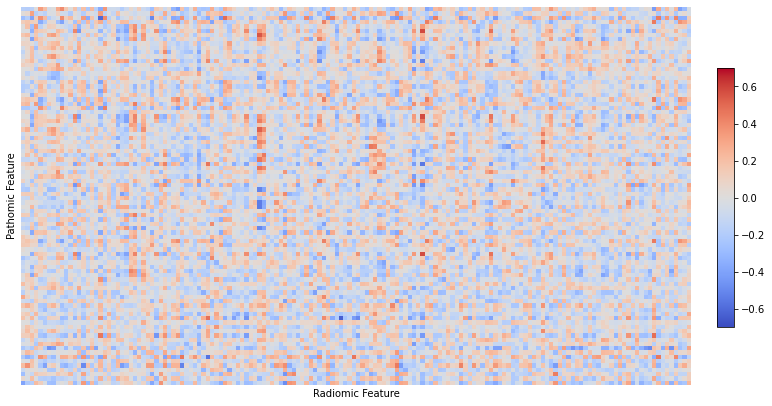

In [14]:
# Étape 1: Créez une matrice vide
all_radio_features = radiomic_feature.columns
all_patho_features = pathomic_feature.columns
corr_matrix = pd.DataFrame(data=0, index=all_patho_features, columns=all_radio_features)

# Étape 2: Remplissez la matrice avec vos corrélations significatives
for (radio, patho), coeff in correlations.items():
    corr_matrix.at[patho, radio] = coeff

# Supprimer les lignes qui ont des corrélations nulles
non_zero_rows = corr_matrix.sum(axis=1) != 0
corr_matrix = corr_matrix[non_zero_rows]

# Supprimer les colonnes qui ont des corrélations nulles
non_zero_cols = corr_matrix.sum(axis=0) != 0
corr_matrix = corr_matrix.loc[:, non_zero_cols]
    
# Les noms des variables à sélectionner
feature_names = df_significant_correlations_all['Radio_Feature'].tolist()
corr_matrix = corr_matrix[feature_names]
# Les index à sélectionner
index_names = df_significant_correlations_all['Patho_Feature'].tolist()
# Sélectionnez les lignes de la nouvelle base de données en fonction des observations de Radio_Feature
corr_matrix = corr_matrix.loc[index_names]
# Supprimer les doublons dans l'index tout en conservant la première occurrence
corr_matrix = corr_matrix[~corr_matrix.index.duplicated(keep='first')]
corr_matrix = corr_matrix.T.drop_duplicates().T
corr_matrix_all = corr_matrix
# Étape 3: Visualisez la heatmap
# plt.figure(figsize=(12, 9))
# sns.heatmap(corr_matrix, cmap="coolwarm", cbar=True, square=True, vmin=-0.7, vmax=0.7, xticklabels=False, yticklabels=False)
# ##plt.title("Heatmap of Significant Correlations")
# plt.savefig('heatmaps_V2_all.png', dpi=600, bbox_inches='tight')
# plt.show()

# Créer une figure
fig = plt.figure(figsize=(12, 9))

# Créer la heatmap sans barre de couleur
ax = sns.heatmap(corr_matrix, cmap="coolwarm", cbar=False, square=True, 
                 vmin=-0.7, vmax=0.7, xticklabels=False, yticklabels=False)
# Ajouter les titres des axes
ax.set_xlabel('Radiomic Feature')
ax.set_ylabel('Pathomic Feature')
# Spécifiez la position et la taille de la barre de couleur. 
# [x_position, y_position, width, height]
cbar_ax = fig.add_axes([0.93, 0.3, 0.02, 0.4])
# Ajoutez la barre de couleur avec la hauteur personnalisée
fig.colorbar(ax.collections[0], cax=cbar_ax)
# Sauvegardez la figure
plt.savefig('heatmaps_V2_all.png', dpi=600, bbox_inches='tight')
plt.show()

## Correlation within pathomic feature and pfs feature

In [77]:


pathomic_feature_16_reduce.columns = [col + '_16' for col in pathomic_feature_16_reduce.columns]
pathomic_feature_32_reduce.columns = [col + '_32' for col in pathomic_feature_32_reduce.columns]
pathomic_feature_64_reduce.columns = [col + '_64' for col in pathomic_feature_64_reduce.columns]

## Merge radiomic, pathomic feature and pfs/os data
merge1 = pd.merge(pathomic_feature_16_reduce, pathomic_feature_32_reduce, left_index=True, right_index=True, how='inner')
pathomic_feature_all = pd.merge(merge1, pathomic_feature_64_reduce, left_index=True, right_index=True, how='inner')
pathomic_feature_pfs = pd.merge(pathomic_feature_all, subset_CHUM_IUCPQ, left_index=True, right_index=True, how='inner')
pfs_os_feature =  pathomic_feature_pfs.iloc[:, 89:90]
pathomic_feature = pathomic_feature_pfs.iloc[:, :88]


correlations = {}
p_values = []
significant_correlations = {}  # Pour stocker les corrélations significatives

for pfs_os in [col for col in pfs_os_feature.columns]:
    for patho_feature in [col for col in pathomic_feature.columns]:
        coeff, p = spearmanr(pfs_os_feature[pfs_os], pathomic_feature[patho_feature])
        correlations[(pfs_os, patho_feature)] = coeff
        p_values.append(p)
        if abs(coeff) > 0.3:  # Nous vérifions la valeur absolue car la corrélation peut être négative
            significant_correlations[(pfs_os, patho_feature)] = coeff

# Convertir le dictionnaire en DataFrame
df_significant_correlations_pfs_pat = pd.DataFrame(list(correlations.items()), columns=['Features_Pair', 'Correlation'])

# Si vous souhaitez diviser les paires de fonctionnalités en deux colonnes distinctes :
df_significant_correlations_pfs_pat['pfs_Feature'] = df_significant_correlations_pfs_pat['Features_Pair'].apply(lambda x: x[0])
df_significant_correlations_pfs_pat['Patho_Feature'] = df_significant_correlations_pfs_pat['Features_Pair'].apply(lambda x: x[1])
df_significant_correlations_pfs_pat = df_significant_correlations_pfs_pat.drop('Features_Pair', axis=1)

# Réorganiser les colonnes pour une meilleure lisibilité
df_significant_correlations_pfs_pat = df_significant_correlations_pfs_pat[['pfs_Feature', 'Patho_Feature', 'Correlation']] 
# Ajouter une colonne avec le numéro de l'observation
df_significant_correlations_pfs_pat['Feature'] = range(1, len(df_significant_correlations_pfs_pat) + 1)
            
# Afficher les corrélations significatives
for (pfs_os, patho), coeff in significant_correlations.items():
    print(f"Correlation within {pfs_os} and {patho} : {coeff:.3f}")

Correlation within pfs_days and skewness_sum_variance_D3_32 : 0.317
Correlation within pfs_days and mean_contrast_D1_64 : -0.319
Correlation within pfs_days and median_IDM_D3_64 : 0.330
Correlation within pfs_days and skewness_contrast_D1_64 : 0.322
Correlation within pfs_days and skewness_IMC1_D3_64 : -0.323


In [79]:
df_significant_correlations_pfs_pat.describe()

,Correlation,Feature
count,88.000000,88.000000
mean,0.029229,44.500000
std,0.163748,25.547342
min,-0.322810,1.000000
25%,-0.087675,22.750000
50%,0.025304,44.500000
75%,0.146963,66.250000
max,0.330400,88.000000


## Correlation within pathomic feature and OS feature

In [80]:


# pathomic_feature_16_reduce.columns = [col + '_16' for col in pathomic_feature_16_reduce.columns]
# pathomic_feature_32_reduce.columns = [col + '_32' for col in pathomic_feature_32_reduce.columns]
# pathomic_feature_64_reduce.columns = [col + '_64' for col in pathomic_feature_64_reduce.columns]

## Merge radiomic, pathomic feature and pfs/os data
# merge1 = pd.merge(pathomic_feature_16_reduce, pathomic_feature_32_reduce, left_index=True, right_index=True, how='inner')
# pathomic_feature_all = pd.merge(merge1, pathomic_feature_64_reduce, left_index=True, right_index=True, how='inner')
# pathomic_feature_pfs = pd.merge(pathomic_feature_all, subset_CHUM_IUCPQ, left_index=True, right_index=True, how='inner')
pfs_os_feature =  pathomic_feature_pfs.iloc[:, 90:91]
pathomic_feature = pathomic_feature_pfs.iloc[:, :88]


correlations = {}
p_values = []
significant_correlations = {}  # Pour stocker les corrélations significatives

for pfs_os in [col for col in pfs_os_feature.columns]:
    for patho_feature in [col for col in pathomic_feature.columns]:
        coeff, p = spearmanr(pfs_os_feature[pfs_os], pathomic_feature[patho_feature])
        correlations[(pfs_os, patho_feature)] = coeff
        p_values.append(p)
        if abs(coeff) > 0.3:  # Nous vérifions la valeur absolue car la corrélation peut être négative
            significant_correlations[(pfs_os, patho_feature)] = coeff

# Convertir le dictionnaire en DataFrame
df_significant_correlations_pfs_pat = pd.DataFrame(list(correlations.items()), columns=['Features_Pair', 'Correlation'])

# Si vous souhaitez diviser les paires de fonctionnalités en deux colonnes distinctes :
df_significant_correlations_pfs_pat['pfs_Feature'] = df_significant_correlations_pfs_pat['Features_Pair'].apply(lambda x: x[0])
df_significant_correlations_pfs_pat['Patho_Feature'] = df_significant_correlations_pfs_pat['Features_Pair'].apply(lambda x: x[1])
df_significant_correlations_pfs_pat = df_significant_correlations_pfs_pat.drop('Features_Pair', axis=1)

# Réorganiser les colonnes pour une meilleure lisibilité
df_significant_correlations_pfs_pat = df_significant_correlations_pfs_pat[['pfs_Feature', 'Patho_Feature', 'Correlation']] 
# Ajouter une colonne avec le numéro de l'observation
df_significant_correlations_pfs_pat['Feature'] = range(1, len(df_significant_correlations_pfs_pat) + 1)
df_significant_correlations_os_pat = df_significant_correlations_pfs_pat
            
# Afficher les corrélations significatives
for (pfs_os, patho), coeff in significant_correlations.items():
    print(f"Correlation within {pfs_os} and {patho} : {coeff:.3f}")

Correlation within os_days and skewness_sum_variance_D3_32 : 0.319
Correlation within os_days and kurtosis_IMC1_D1_64 : -0.310
Correlation within os_days and kurtosis_IMC1_D2_64 : -0.343
Correlation within os_days and skewness_contrast_D1_64 : 0.337


In [81]:
df_significant_correlations_os_pat.describe()

,Correlation,Feature
count,88.000000,88.000000
mean,0.003420,44.500000
std,0.157969,25.547342
min,-0.343231,1.000000
25%,-0.136255,22.750000
50%,0.021989,44.500000
75%,0.129005,66.250000
max,0.336876,88.000000


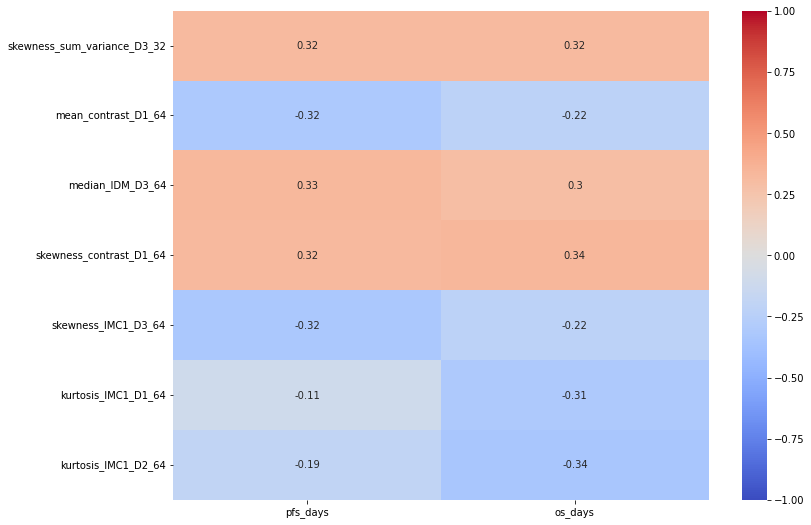

In [79]:
# Étape 1: Créez une matrice vide
pfs_feature = pfs_os_feature.columns
all_patho_features = pathomic_feature.columns
corr_matrix = pd.DataFrame(data=0, index=all_patho_features, columns=pfs_feature)

# Étape 2: Remplissez la matrice avec vos corrélations significatives
for (pfs_os, patho), coeff in correlations.items():
    corr_matrix.at[patho, pfs_os] = coeff

# Supprimer les lignes qui ont des corrélations nulles
non_zero_rows = corr_matrix.sum(axis=1) != 0
corr_matrix = corr_matrix[non_zero_rows]

# Supprimer les colonnes qui ont des corrélations nulles
non_zero_cols = corr_matrix.sum(axis=0) != 0
corr_matrix = corr_matrix.loc[:, non_zero_cols]
    
# Les noms des variables à sélectionner
feature_names = df_significant_correlations_pfs_pat['pfs_Feature'].tolist()
corr_matrix = corr_matrix[feature_names]
# Les index à sélectionner
index_names = df_significant_correlations_pfs_pat['Patho_Feature'].tolist()
# Sélectionnez les lignes de la nouvelle base de données en fonction des observations de Radio_Feature
corr_matrix = corr_matrix.loc[index_names]
# Supprimer les doublons dans l'index tout en conservant la première occurrence
corr_matrix = corr_matrix[~corr_matrix.index.duplicated(keep='first')]
corr_matrix = corr_matrix.T.drop_duplicates().T
# Étape 3: Visualisez la heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, cbar=True, vmin=-1, vmax=1)
##plt.title("Heatmap of Significant Correlations")
plt.savefig('heatmaps_V2_pfs.png', dpi=300, bbox_inches='tight')
plt.show()

## False Discovery Rate

In [18]:
# Apply FDR correction
rejected, corrected_p_values, _, _ = multipletests(p_values, alpha=0.01, method='fdr_bh')
# Use a flag to determine if significant correlations were found
found_significant = False

# Display significant correlations
for idx, (pair, coeff) in enumerate(correlations.items()):
    if rejected[idx] and corrected_p_values[idx] <= 0.01:
        print(f"Significant correlation between {pair[0]} and {pair[1]} with coefficient: {coeff:.3f} and corrected p-value: {corrected_p_values[idx]:.5f}")
        found_significant = True

# If no significant correlations were found, print the respective message
if not found_significant:
    print("No Significant correlation")

No Significant correlation


## Correlation between CD8 and Pathomic features

In [9]:


# pathomic_feature_16_reduce.columns = [col + '_16' for col in pathomic_feature_16_reduce.columns]
# pathomic_feature_32_reduce.columns = [col + '_32' for col in pathomic_feature_32_reduce.columns]
# pathomic_feature_64_reduce.columns = [col + '_64' for col in pathomic_feature_64_reduce.columns]

## Merge radiomic, pathomic feature and pfs/os data
# merge1 = pd.merge(pathomic_feature_16_reduce, pathomic_feature_32_reduce, left_index=True, right_index=True, how='inner')
# pathomic_feature_all = pd.merge(merge1, pathomic_feature_64_reduce, left_index=True, right_index=True, how='inner')
# pathomic_feature_pfs = pd.merge(pathomic_feature_all, subset_CHUM_IUCPQ, left_index=True, right_index=True, how='inner')
pfs_os_feature =  pathomic_feature_pfs.iloc[:, 88:89]
pathomic_feature = pathomic_feature_pfs.iloc[:, :88]


correlations = {}
p_values = []
significant_correlations = {}  # Pour stocker les corrélations significatives

for pfs_os in [col for col in pfs_os_feature.columns]:
    for patho_feature in [col for col in pathomic_feature.columns]:
        coeff, p = spearmanr(pfs_os_feature[pfs_os], pathomic_feature[patho_feature])
        correlations[(pfs_os, patho_feature)] = coeff
        p_values.append(p)
        if abs(coeff) > 0.3:  # Nous vérifions la valeur absolue car la corrélation peut être négative
            significant_correlations[(pfs_os, patho_feature)] = coeff

# Convertir le dictionnaire en DataFrame
df_significant_correlations_cd8_pat = pd.DataFrame(list(correlations.items()), columns=['Features_Pair', 'Correlation'])

# Si vous souhaitez diviser les paires de fonctionnalités en deux colonnes distinctes :
df_significant_correlations_cd8_pat['pfs_Feature'] = df_significant_correlations_cd8_pat['Features_Pair'].apply(lambda x: x[0])
df_significant_correlations_cd8_pat['Patho_Feature'] = df_significant_correlations_cd8_pat['Features_Pair'].apply(lambda x: x[1])
df_significant_correlations_cd8_pat = df_significant_correlations_cd8_pat.drop('Features_Pair', axis=1)

# Réorganiser les colonnes pour une meilleure lisibilité
df_significant_correlations_cd8_pat = df_significant_correlations_cd8_pat[['pfs_Feature', 'Patho_Feature', 'Correlation']] 
# Ajouter une colonne avec le numéro de l'observation
df_significant_correlations_cd8_pat['Feature'] = range(1, len(df_significant_correlations_cd8_pat) + 1)

            
# Afficher les corrélations significatives
for (pfs_os, patho), coeff in significant_correlations.items():
    print(f"Correlation within {pfs_os} and {patho} : {coeff:.3f}")

Correlation within CD8_PercTumor and kurtosis_sum_average_D1_16 : 0.316
Correlation within CD8_PercTumor and kurtosis_sum_variance_D2_16 : 0.331
Correlation within CD8_PercTumor and skewness_correlation_D1_16 : 0.302
Correlation within CD8_PercTumor and median_correlation_D1_32 : -0.347
Correlation within CD8_PercTumor and var_sum_variance_D2_32 : -0.336
Correlation within CD8_PercTumor and kurtosis_sum_average_D2_32 : 0.316
Correlation within CD8_PercTumor and skewness_correlation_D1_32 : 0.351
Correlation within CD8_PercTumor and var_correlation_D1_64 : -0.331
Correlation within CD8_PercTumor and var_contrast_D4_64 : -0.315
Correlation within CD8_PercTumor and kurtosis_sum_average_D1_64 : 0.315


In [28]:
df_significant_correlations_cd8_pat.head()

,pfs_Feature,Patho_Feature,Correlation,Feature
0,CD8_PercTumor,median_contrast_D1_16,-0.346882,1
1,CD8_PercTumor,median_IMC1_D1_16,-0.336040,2
2,CD8_PercTumor,median_sum_variance_D2_16,-0.331148,3
3,CD8_PercTumor,median_sum_average_D3_16,-0.314758,4
4,CD8_PercTumor,var_correlation_D1_16,-0.299478,5


<AxesSubplot:xlabel='Feature', ylabel='Correlation'>

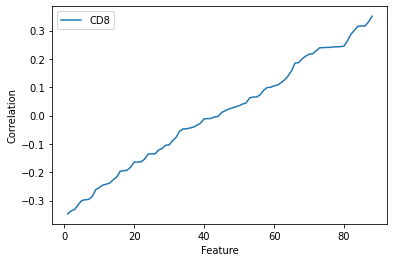

In [16]:
sorted_indices = np.argsort(df_significant_correlations_cd8_pat['Correlation'])
df_significant_correlations_cd8_pat['Correlation'] = df_significant_correlations_cd8_pat['Correlation'].iloc[sorted_indices].values
sns.lineplot(
    data=df_significant_correlations_cd8_pat,
    x="Feature", y="Correlation",
    errorbar=None, label='CD8'
)

In [40]:
pos_corr_pfs = (df_significant_correlations_pfs_pat['Correlation'] > 0).sum()
neg_corr_pfs = (df_significant_correlations_pfs_pat['Correlation'] < 0).sum()

pos_corr_os = (df_significant_correlations_os_pat['Correlation'] > 0).sum()
neg_corr_os = (df_significant_correlations_os_pat['Correlation'] < 0).sum()

pos_corr_cd8 = (df_significant_correlations_cd8_pat['Correlation'] > 0).sum()
neg_corr_cd8 = (df_significant_correlations_cd8_pat['Correlation'] < 0).sum()

print ('pfs', pos_corr_pfs, neg_corr_pfs, 'OS', pos_corr_os, neg_corr_os, 'CD8', pos_corr_cd8, neg_corr_cd8)

pfs 54 34 OS 47 41 CD8 44 44


In [11]:
sorted_indices = np.argsort(df_significant_correlations_os_pat['Correlation'])
df_significant_correlations_os_pat['Correlation'] = df_significant_correlations_os_pat['Correlation'].iloc[sorted_indices].values

sorted_indices = np.argsort(df_significant_correlations_cd8_pat['Correlation'])
df_significant_correlations_cd8_pat['Correlation'] = df_significant_correlations_cd8_pat['Correlation'].iloc[sorted_indices].values

sorted_indices = np.argsort(df_significant_correlations_pfs_pat['Correlation'])
df_significant_correlations_pfs_pat['Correlation'] = df_significant_correlations_pfs_pat['Correlation'].iloc[sorted_indices].values

In [13]:
df_significant_correlations_os_pat.to_csv('correlations_os_pat.csv', index=False)
df_significant_correlations_cd8_pat.to_csv('correlations_cd8_pat.csv', index=False)
df_significant_correlations_pfs_pat.to_csv('correlations_pfs_pat.csv', index=False)

In [ ]:
# df_significant_correlations_os_pat.rename(columns={'Feature': 'Features'}, inplace=True)
# df_significant_correlations_cd8_pat.rename(columns={'Feature': 'Features'}, inplace=True)
# df_significant_correlations_pfs_pat.rename(columns={'Feature': 'Features'}, inplace=True)

plt.figure(figsize=(10, 6))

sorted_indices = np.argsort(df_significant_correlations_os_pat['Correlation'])
df_significant_correlations_os_pat['Correlation'] = df_significant_correlations_os_pat['Correlation'].iloc[sorted_indices].values
sns.lineplot(
    data=df_significant_correlations_os_pat,
    x="Features", y="Correlation",
    errorbar=None, label='OS', marker='o', linestyle=''
)

sorted_indices = np.argsort(df_significant_correlations_cd8_pat['Correlation'])
df_significant_correlations_cd8_pat['Correlation'] = df_significant_correlations_cd8_pat['Correlation'].iloc[sorted_indices].values
sns.lineplot(
    data=df_significant_correlations_cd8_pat,
    x="Features", y="Correlation",
    errorbar=None, label='CD8', marker='o',linestyle=''
)

sorted_indices = np.argsort(df_significant_correlations_pfs_pat['Correlation'])
df_significant_correlations_pfs_pat['Correlation'] = df_significant_correlations_pfs_pat['Correlation'].iloc[sorted_indices].values
sns.lineplot(
    data=df_significant_correlations_pfs_pat,
    x="Features", y="Correlation", label='PFS',
    errorbar=None, marker='o',linestyle=''
)
plt.savefig('corr_pfs_os_cd8.png', dpi=600, bbox_inches='tight')
plt.show()


## Correlation within radiomic feature and pfs

In [ ]:
pfs_feature =  radiomic_feature_pfs.iloc[:, 1:2]
pfs_feature.head()

In [15]:
radiomic_feature_pfs = pd.merge(subset_CHUM_IUCPQ, radiomic_feature_reduce, left_index=True, right_index=True, how='inner')
pfs_feature =  radiomic_feature_pfs.iloc[:, 1:2]
radiomic_feature = radiomic_feature_pfs.iloc[:, 4:]

In [16]:

correlations = {}
p_values = []
significant_correlations = {}  # Pour stocker les corrélations significatives

## Merge radiomic, pathomic feature and pfs/os data
radiomic_feature_pfs = pd.merge(subset_CHUM_IUCPQ, radiomic_feature_reduce, left_index=True, right_index=True, how='inner')
pfs_feature =  radiomic_feature_pfs.iloc[:, 1:2]
radiomic_feature = radiomic_feature_pfs.iloc[:, 4:]


for pfs in [col for col in pfs_feature.columns]:
    for radio_feature in [col for col in radiomic_feature.columns]:
        coeff, p = spearmanr(pfs_feature[pfs], radiomic_feature[radio_feature])
        correlations[(pfs, radio_feature)] = coeff
        p_values.append(p)
        if abs(coeff) > 0.26:  # Nous vérifions la valeur absolue car la corrélation peut être négative
            significant_correlations[(pfs, radio_feature)] = coeff

# Convertir le dictionnaire en DataFrame
df_significant_correlations_pfs_rad = pd.DataFrame(list(correlations.items()), columns=['Features_Pair', 'Correlation'])

# Si vous souhaitez diviser les paires de fonctionnalités en deux colonnes distinctes :
df_significant_correlations_pfs_rad['pfs_Feature'] = df_significant_correlations_pfs_rad['Features_Pair'].apply(lambda x: x[0])
df_significant_correlations_pfs_rad['radio_Feature'] = df_significant_correlations_pfs_rad['Features_Pair'].apply(lambda x: x[1])
df_significant_correlations_pfs_rad = df_significant_correlations_pfs_rad.drop('Features_Pair', axis=1)

# Réorganiser les colonnes pour une meilleure lisibilité
df_significant_correlations_pfs_rad = df_significant_correlations_pfs_rad[['pfs_Feature', 'radio_Feature', 'Correlation']] 
# Ajouter une colonne avec le numéro de l'observation
df_significant_correlations_pfs_rad['Features'] = range(1, len(df_significant_correlations_pfs_rad) + 1)

corr_pfs = df_significant_correlations_pfs_rad

# Afficher les corrélations significatives
for (pfs_os, radio), coeff in significant_correlations.items():
    print(f"Correlation within {pfs_os} and {radio} : {coeff:.3f}")

Correlation within pfs_days and wavelet.LLH_glszm_GrayLevelVariance : 0.273


In [53]:
df_significant_correlations_pfs_rad.head()

,pfs_Feature,radio_Feature,Correlation,Features
0,pfs_days,original_shape_Elongation,-0.037508,1
1,pfs_days,original_shape_Flatness,0.018021,2
2,pfs_days,original_shape_Maximum3DDiameter,-0.113157,3
3,pfs_days,original_shape_Sphericity,0.050293,4
4,pfs_days,original_shape_SurfaceVolumeRatio,0.099435,5


## Correlation within radiomic feature and cd8

In [17]:

correlations = {}
p_values = []
significant_correlations = {}  # Pour stocker les corrélations significatives

## Merge radiomic, pathomic feature and pfs/os data
radiomic_feature_pfs = pd.merge(subset_CHUM_IUCPQ, radiomic_feature_reduce, left_index=True, right_index=True, how='inner')
pfs_feature =  radiomic_feature_pfs.iloc[:, 2:3]
radiomic_feature = radiomic_feature_pfs.iloc[:, 4:]


for pfs in [col for col in pfs_feature.columns]:
    for radio_feature in [col for col in radiomic_feature.columns]:
        coeff, p = spearmanr(pfs_feature[pfs], radiomic_feature[radio_feature])
        correlations[(pfs, radio_feature)] = coeff
        p_values.append(p)
        if abs(coeff) > 0.26:  # Nous vérifions la valeur absolue car la corrélation peut être négative
            significant_correlations[(pfs, radio_feature)] = coeff

# Convertir le dictionnaire en DataFrame
df_significant_correlations_pfs_rad = pd.DataFrame(list(correlations.items()), columns=['Features_Pair', 'Correlation'])

# Si vous souhaitez diviser les paires de fonctionnalités en deux colonnes distinctes :
df_significant_correlations_pfs_rad['pfs_Feature'] = df_significant_correlations_pfs_rad['Features_Pair'].apply(lambda x: x[0])
df_significant_correlations_pfs_rad['radio_Feature'] = df_significant_correlations_pfs_rad['Features_Pair'].apply(lambda x: x[1])
df_significant_correlations_pfs_rad = df_significant_correlations_pfs_rad.drop('Features_Pair', axis=1)

# Réorganiser les colonnes pour une meilleure lisibilité
df_significant_correlations_pfs_rad = df_significant_correlations_pfs_rad[['pfs_Feature', 'radio_Feature', 'Correlation']] 
# Ajouter une colonne avec le numéro de l'observation
df_significant_correlations_pfs_rad['Features'] = range(1, len(df_significant_correlations_pfs_rad) + 1)
corr_os = df_significant_correlations_pfs_rad

# Afficher les corrélations significatives
for (pfs_os, radio), coeff in significant_correlations.items():
    print(f"Correlation within {pfs_os} and {radio} : {coeff:.3f}")

Correlation within os_days and wavelet.LLH_glcm_ClusterProminence : 0.298
Correlation within os_days and wavelet.LLH_glszm_GrayLevelVariance : 0.264
Correlation within os_days and wavelet.LLH_ngtdm_Strength : 0.320
Correlation within os_days and wavelet.LHH_glcm_Imc2 : 0.280
Correlation within os_days and wavelet.LHH_glcm_MCC : 0.369


In [18]:

correlations = {}
p_values = []
significant_correlations = {}  # Pour stocker les corrélations significatives

## Merge radiomic, pathomic feature and pfs/os data
radiomic_feature_pfs = pd.merge(subset_CHUM_IUCPQ, radiomic_feature_reduce, left_index=True, right_index=True, how='inner')
pfs_feature =  radiomic_feature_pfs.iloc[:, 0:1]
radiomic_feature = radiomic_feature_pfs.iloc[:, 4:]


# for pfs in [col for col in pfs_feature.columns]:
#     for radio_feature in [col for col in radiomic_feature.columns]:
#         coeff, p = spearmanr(pfs_feature[pfs], radiomic_feature[radio_feature])
#         correlations[(pfs, radio_feature)] = coeff
#         p_values.append(p)
#         if abs(coeff) > 0.26:  # Nous vérifions la valeur absolue car la corrélation peut être négative
#             significant_correlations[(pfs, radio_feature)] = coeff

# Assuming pfs_feature and radiomic_feature are DataFrames
for pfs in pfs_feature.columns:
    for radio_feature in radiomic_feature.columns:
        coeff = pfs_feature[pfs].corr(radiomic_feature[radio_feature], method='spearman')
        correlations[(pfs, radio_feature)] = coeff
        
        # NOTE: Using the corr() function will only provide the correlation coefficient, not the p-value. 
        # If you need p-values, you will still need to rely on spearmanr or another statistical method.
        
        if abs(coeff) > 0.3:  # Check the absolute value as correlation can be negative
            significant_correlations[(pfs, radio_feature)] = coeff


# Convertir le dictionnaire en DataFrame
df_significant_correlations_pfs_rad = pd.DataFrame(list(correlations.items()), columns=['Features_Pair', 'Correlation'])

# Si vous souhaitez diviser les paires de fonctionnalités en deux colonnes distinctes :
df_significant_correlations_pfs_rad['pfs_Feature'] = df_significant_correlations_pfs_rad['Features_Pair'].apply(lambda x: x[0])
df_significant_correlations_pfs_rad['radio_Feature'] = df_significant_correlations_pfs_rad['Features_Pair'].apply(lambda x: x[1])
df_significant_correlations_pfs_rad = df_significant_correlations_pfs_rad.drop('Features_Pair', axis=1)

# Réorganiser les colonnes pour une meilleure lisibilité
df_significant_correlations_pfs_rad = df_significant_correlations_pfs_rad[['pfs_Feature', 'radio_Feature', 'Correlation']] 
# Ajouter une colonne avec le numéro de l'observation
df_significant_correlations_pfs_rad['Features'] = range(1, len(df_significant_correlations_pfs_rad) + 1)

corr_cd8 = df_significant_correlations_pfs_rad

# Afficher les corrélations significatives
for (pfs_os, radio), coeff in significant_correlations.items():
    print(f"Correlation within {pfs_os} and {radio} : {coeff:.3f}")

Correlation within CD8_PercTumor and original_firstorder_Mean : 0.318
Correlation within CD8_PercTumor and original_glcm_DifferenceVariance : 0.336
Correlation within CD8_PercTumor and original_glrlm_ShortRunHighGrayLevelEmphasis : 0.366
Correlation within CD8_PercTumor and original_gldm_SmallDependenceHighGrayLevelEmphasis : 0.374
Correlation within CD8_PercTumor and wavelet.LLH_firstorder_Minimum : -0.338
Correlation within CD8_PercTumor and wavelet.LLH_glcm_ClusterProminence : 0.337
Correlation within CD8_PercTumor and wavelet.LLH_glszm_GrayLevelVariance : 0.356
Correlation within CD8_PercTumor and wavelet.LLH_glszm_ZoneEntropy : 0.303
Correlation within CD8_PercTumor and wavelet.LLH_ngtdm_Complexity : 0.406
Correlation within CD8_PercTumor and wavelet.LHL_glszm_ZoneEntropy : 0.398
Correlation within CD8_PercTumor and wavelet.LHH_glszm_ZoneEntropy : 0.335
Correlation within CD8_PercTumor and wavelet.LLL_firstorder_90Percentile : 0.392
Correlation within CD8_PercTumor and wavelet.LLL

In [35]:
pos_corr_pfs = (corr_pfs['Correlation'] > 0).sum()
neg_corr_pfs = (corr_pfs['Correlation'] < 0).sum()

pos_corr_os = (corr_os['Correlation'] > 0).sum()
neg_corr_os = (corr_os['Correlation'] < 0).sum()

pos_corr_cd8 = (corr_cd8['Correlation'] > 0).sum()
neg_corr_cd8 = (corr_cd8['Correlation'] < 0).sum()

print ('pfs', pos_corr_pfs, neg_corr_pfs, 'OS', pos_corr_os, neg_corr_os, 'CD8', pos_corr_cd8, neg_corr_cd8)

pfs 82 74 OS 83 73 CD8 106 50


In [34]:
corr_cd8.describe()

,Correlation,Features
count,156.000000,156.000000
mean,0.082161,78.500000
std,0.173496,45.177428
min,-0.338293,1.000000
25%,-0.049477,39.750000
50%,0.072677,78.500000
75%,0.231282,117.250000
max,0.405568,156.000000


In [19]:
sorted_indices = np.argsort(corr_os['Correlation'])
corr_os['Correlation'] = corr_os['Correlation'].iloc[sorted_indices].values

sorted_indices = np.argsort(corr_cd8['Correlation'])
corr_cd8['Correlation'] = corr_cd8['Correlation'].iloc[sorted_indices].values

sorted_indices = np.argsort(corr_pfs['Correlation'])
corr_pfs['Correlation'] = corr_pfs['Correlation'].iloc[sorted_indices].values

In [20]:
corr_os.to_csv('correlations_os_rad.csv', index=False)
corr_cd8.to_csv('correlations_cd8_rad.csv', index=False)
corr_pfs.to_csv('correlations_cd8_rad.csv', index=False)

,pfs_Feature,radio_Feature,Correlation,Features
0,os_days,original_shape_Elongation,-0.258561,1
1,os_days,original_shape_Flatness,-0.253642,2
2,os_days,original_shape_Maximum3DDiameter,-0.239909,3
3,os_days,original_shape_Sphericity,-0.218233,4
4,os_days,original_shape_SurfaceVolumeRatio,-0.210506,5
...,...,...,...,...
151,os_days,wavelet.LLL_ngtdm_Complexity,0.263961,152
152,os_days,wavelet.LLL_ngtdm_Contrast,0.280009,153
153,os_days,wavelet.LLL_gldm_DependenceEntropy,0.297638,154
154,os_days,wavelet.LLL_gldm_LargeDependenceHighGrayLevelE...,0.319857,155


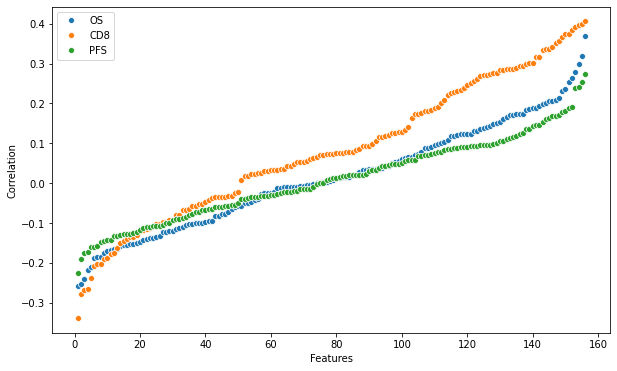

In [30]:
corr_pfs.rename(columns={'Feature': 'Features'}, inplace=True)
corr_os.rename(columns={'Feature': 'Features'}, inplace=True)
corr_cd8.rename(columns={'Feature': 'Features'}, inplace=True)

plt.figure(figsize=(10, 6))

sorted_indices = np.argsort(corr_os['Correlation'])
corr_os['Correlation'] = corr_os['Correlation'].iloc[sorted_indices].values
sns.lineplot(
    data=corr_os,
    x="Features", y="Correlation",
    errorbar=None, label='OS', marker='o', linestyle=''
)

sorted_indices = np.argsort(corr_cd8['Correlation'])
corr_cd8['Correlation'] = corr_cd8['Correlation'].iloc[sorted_indices].values
sns.lineplot(
    data=corr_cd8,
    x="Features", y="Correlation",
    errorbar=None, label='CD8', marker='o',linestyle=''
)

sorted_indices = np.argsort(corr_pfs['Correlation'])
corr_pfs['Correlation'] = corr_pfs['Correlation'].iloc[sorted_indices].values
sns.lineplot(
    data=corr_pfs,
    x="Features", y="Correlation", label='PFS',
    errorbar=None, marker='o',linestyle=''
)
plt.savefig('corr_pfs_os_cd8_radio.png', dpi=600, bbox_inches='tight')
plt.show()


## Correlation within radiomic feature and OS

In [77]:

correlations = {}
p_values = []
significant_correlations = {}  # Pour stocker les corrélations significatives

pathomic_feature = radio_pathomic_pfs_os_feature_16.iloc[:, :17]
pfs_os_feature = radio_pathomic_pfs_os_feature_16.iloc[:, 18:19]
radiomic_feature =  radio_pathomic_pfs_os_feature_16.iloc[:, 20:]


for pfs_os in [col for col in pfs_os_feature.columns]:
    for radio_feature in [col for col in radiomic_feature.columns]:
        coeff, p = spearmanr(pfs_os_feature[pfs_os], radiomic_feature[radio_feature])
        correlations[(pfs_os, radio_feature)] = coeff
        p_values.append(p)
        if abs(coeff) > 0.26:  # Nous vérifions la valeur absolue car la corrélation peut être négative
            significant_correlations[(pfs_os, radio_feature)] = coeff

# Convertir le dictionnaire en DataFrame
df_significant_correlations_pfs_rad = pd.DataFrame(list(correlations.items()), columns=['Features_Pair', 'Correlation'])

# Si vous souhaitez diviser les paires de fonctionnalités en deux colonnes distinctes :
df_significant_correlations_pfs_rad['pfs_Feature'] = df_significant_correlations_pfs_rad['Features_Pair'].apply(lambda x: x[0])
df_significant_correlations_pfs_rad['radio_Feature'] = df_significant_correlations_pfs_rad['Features_Pair'].apply(lambda x: x[1])
df_significant_correlations_pfs_rad = df_significant_correlations_pfs_rad.drop('Features_Pair', axis=1)

# Réorganiser les colonnes pour une meilleure lisibilité
df_significant_correlations_pfs_rad = df_significant_correlations_pfs_rad[['pfs_Feature', 'radio_Feature', 'Correlation']] 
# Ajouter une colonne avec le numéro de l'observation
df_significant_correlations_pfs_rad['Features'] = range(1, len(df_significant_correlations_pfs_rad) + 1)

# Afficher les corrélations significatives
for (pfs_os, radio), coeff in significant_correlations.items():
    print(f"Correlation within {pfs_os} and {radio} : {coeff:.3f}")

Correlation within os_days and original_shape_Sphericity : -0.291
Correlation within os_days and wavelet.LLH_ngtdm_Strength : 0.336
Correlation within os_days and wavelet.LLH_gldm_DependenceEntropy : -0.262
Correlation within os_days and wavelet.LHL_glcm_Imc2 : 0.263
Correlation within os_days and wavelet.LHL_glcm_MCC : 0.363
Correlation within os_days and wavelet.LHH_glcm_Imc1 : -0.304
Correlation within os_days and wavelet.LHH_glcm_Imc2 : 0.298
Correlation within os_days and wavelet.LHH_glcm_MCC : 0.388
Correlation within os_days and wavelet.HLH_glcm_MCC : 0.339
Correlation within os_days and wavelet.HHL_firstorder_Median : 0.336
Correlation within os_days and wavelet.HHH_glcm_Imc1 : -0.276
Correlation within os_days and wavelet.LLL_firstorder_RootMeanSquared : 0.287


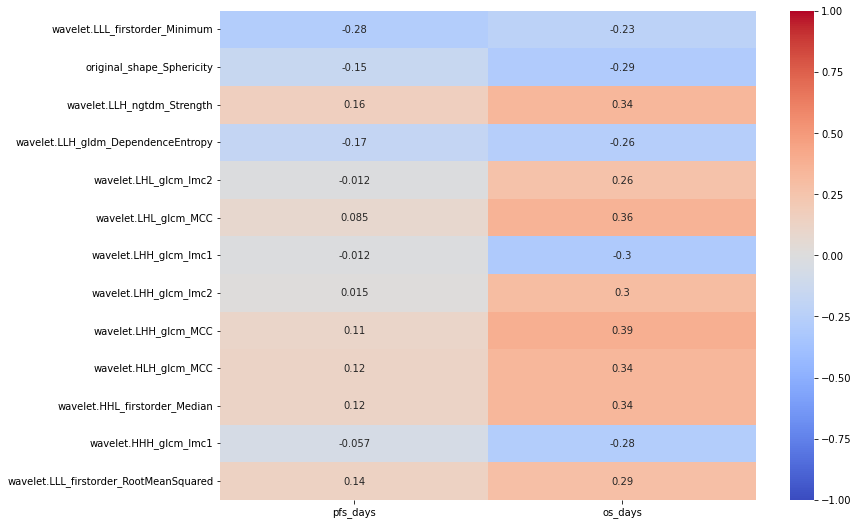

In [83]:
# Étape 1: Créez une matrice vide
pfs_feature = pfs_os_feature.columns
all_radio_features = radiomic_feature.columns
corr_matrix = pd.DataFrame(data=0, index=all_radio_features, columns=pfs_feature)

# Étape 2: Remplissez la matrice avec vos corrélations significatives
for (pfs_os, radio), coeff in correlations.items():
    corr_matrix.at[radio, pfs_os] = coeff

# Supprimer les lignes qui ont des corrélations nulles
non_zero_rows = corr_matrix.sum(axis=1) != 0
corr_matrix = corr_matrix[non_zero_rows]

# Supprimer les colonnes qui ont des corrélations nulles
non_zero_cols = corr_matrix.sum(axis=0) != 0
corr_matrix = corr_matrix.loc[:, non_zero_cols]
    
# Les noms des variables à sélectionner
feature_names = df_significant_correlations_pfs_rad['pfs_Feature'].tolist()
corr_matrix = corr_matrix[feature_names]
# Les index à sélectionner
index_names = df_significant_correlations_pfs_rad['radio_Feature'].tolist()
# Sélectionnez les lignes de la nouvelle base de données en fonction des observations de Radio_Feature
corr_matrix = corr_matrix.loc[index_names]
# Supprimer les doublons dans l'index tout en conservant la première occurrence
corr_matrix = corr_matrix[~corr_matrix.index.duplicated(keep='first')]
corr_matrix = corr_matrix.T.drop_duplicates().T
# Étape 3: Visualisez la heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, cbar=True, vmin=-1, vmax=1)
##plt.title("Heatmap of Significant Correlations")
plt.savefig('heatmaps_V2_pfs_radio.png', dpi=300, bbox_inches='tight')
plt.show()

### False Discovery Rate Correction

In [15]:
# Apply FDR correction
rejected, corrected_p_values, _, _ = multipletests(p_values, alpha=0.01, method='fdr_bh')
# Use a flag to determine if significant correlations were found
found_significant = False

# Display significant correlations
for idx, (pair, coeff) in enumerate(correlations.items()):
    if rejected[idx] and corrected_p_values[idx] <= 0.01:
        print(f"Significant correlation between {pair[0]} and {pair[1]} with coefficient: {coeff:.3f} and corrected p-value: {corrected_p_values[idx]:.5f}")
        found_significant = True

# If no significant correlations were found, print the respective message
if not found_significant:
    print("No Significant correlation")

No Significant correlation


## Factor Analysis

In [35]:
import pandas as pd
from factor_analyzer import FactorAnalyzer

# Assume df is your dataframe
fa = FactorAnalyzer(rotation=None)  # Set rotation to None for now
fa.fit(pathomic_feature_16_reduce)

##determine the number of factor
eigen_values, _ = fa.get_eigenvalues()
n_factors = sum(eigen_values > 1)

##Re-fit the Factor Analysis Model with Chosen Number of Factors and Rotation:
## Rotation can make the output more interpretable. Orthogonal rotation ( Varimax) assumes that the factors are uncorrelated
fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")  # Using varimax rotation
fa.fit(pathomic_feature_16_reduce)

## Factor loadings
## Factor loadings represent the correlation between the original variables and the factor. 
loadings = fa.loadings_
loadings_df = pd.DataFrame(loadings, columns=[f"Factor_{i+1}" for i in range(n_factors)], index=pathomic_feature_16_reduce.columns)
print(loadings_df)


                          Factor_1  Factor_2  Factor_3  Factor_4  Factor_5
median_contrast_D1        0.284850  0.892788 -0.031057  0.089445 -0.050282
median_IMC1_D1            0.269001  0.474309 -0.250226  0.131086  0.754326
median_sum_variance_D2    0.096801  0.436632  0.023724 -0.061624 -0.765080
median_sum_average_D3    -0.110901 -0.968948  0.040172 -0.154299  0.001309
var_correlation_D1       -0.124222  0.016159  0.755322 -0.204938  0.101503
var_sum_average_D1       -0.232392  0.166766  0.859536 -0.282176  0.049019
var_IMC2_D1               0.325938 -0.277931  0.637372 -0.064037 -0.235345
var_sum_variance_D2      -0.049195 -0.167093  0.883057 -0.213680 -0.309417
kurtosis_correlation_D1   0.792454 -0.019608 -0.067349  0.087865  0.025040
kurtosis_sum_average_D1   0.564276  0.388702 -0.371603  0.313048 -0.131725
kurtosis_ASM_D2           0.164960  0.225053 -0.270716  0.923901 -0.004956
kurtosis_sum_variance_D2  0.760746  0.273102 -0.316610 -0.051435 -0.041529
kurtosis_IMC2_D3         

In [43]:
## Communality and Uniqueness:
## Communality represents the proportion of variance in a given variable explained by all the factors jointly. 
communalities = fa.get_communalities()

## Uniqueness represents the variance of the observed variable that is unique to it and not shared with other variables.
uniqueness = 1 - communalities

communalities_df = pd.DataFrame(communalities, columns=["communalities"], index=pathomic_feature_16_reduce.columns)
communalities_df

,communalities
median_contrast_D1,0.889703
median_IMC1_D1,0.946135
median_sum_variance_D2,0.789725
median_sum_average_D3,0.976584
var_correlation_D1,0.638506
var_sum_average_D1,0.902646
var_IMC2_D1,0.649212
var_sum_variance_D2,0.951528
kurtosis_correlation_D1,0.641251
kurtosis_sum_average_D1,0.722936


In [40]:
uniqueness_df = pd.DataFrame(uniqueness, columns=["uniqueness"], index=pathomic_feature_16_reduce.columns)
uniqueness_df

,uniqueness
median_contrast_D1,0.110297
median_IMC1_D1,0.053865
median_sum_variance_D2,0.210275
median_sum_average_D3,0.023416
var_correlation_D1,0.361494
var_sum_average_D1,0.097354
var_IMC2_D1,0.350788
var_sum_variance_D2,0.048472
kurtosis_correlation_D1,0.358749
kurtosis_sum_average_D1,0.277064


In [41]:
## Factor score
factor_scores = fa.transform(pathomic_feature_16_reduce)
factor_scores_df = pd.DataFrame(factor_scores, columns=[f"Factor_{i+1}" for i in range(n_factors)])
factor_scores_df

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,0.821072,0.152238,-0.705219,0.134522,1.795326
1,-0.042149,0.601653,-0.976751,-0.316078,0.846835
2,-1.146242,0.893044,2.999905,-0.478197,2.614345
3,-0.534655,-1.036578,-0.736131,-0.038298,0.611874
4,-1.014793,-1.673921,-1.623790,-0.675195,-0.610443
...,...,...,...,...,...
65,-0.287840,-0.628060,1.197097,-0.027354,-0.663379
66,-0.325499,-0.090143,0.967249,-0.104452,0.092405
67,0.269844,-0.593357,0.619501,0.027221,-0.766664
68,-0.424480,-0.718349,2.802297,0.418629,-1.088844


In [42]:
## Variance Explained by Each Factor:
## This helps in understanding the significance of each factor:

variance = fa.get_factor_variance()
explained_variance_df = pd.DataFrame(list(variance), columns=[f"Factor_{i+1}" for i in range(n_factors)],
                                     index=['SS Loadings', 'Proportion Var', 'Cumulative Var'])
print(explained_variance_df)


                Factor_1  Factor_2  Factor_3  Factor_4  Factor_5
SS Loadings     3.885662  3.178878  3.059387  1.901141  1.480611
Proportion Var  0.228568  0.186993  0.179964  0.111832  0.087095
Cumulative Var  0.228568  0.415561  0.595525  0.707357  0.794452


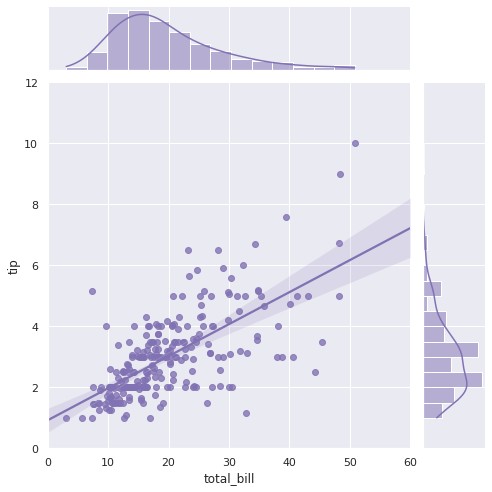

In [84]:
import seaborn as sns
sns.set_theme(style="darkgrid")

tips = sns.load_dataset("tips")
g = sns.jointplot(x="total_bill", y="tip", data=tips,
                  kind="reg", truncate=False,
                  xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7)

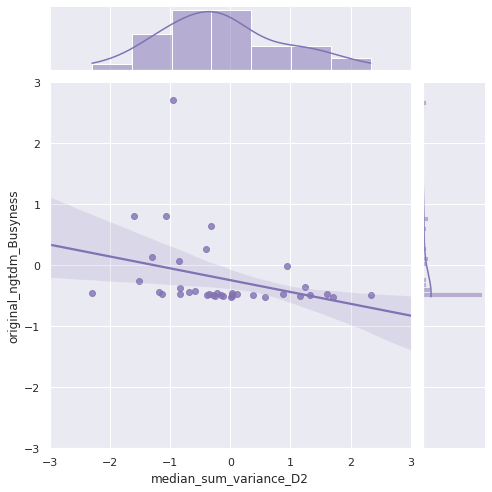

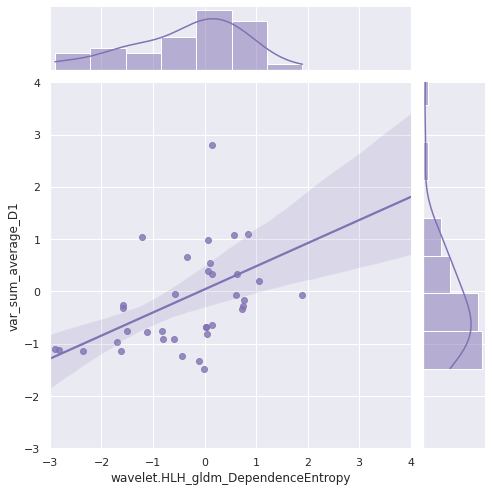

In [98]:
df = radio_pathomic_pfs_os_feature_16[['original_ngtdm_Busyness','median_sum_variance_D2', 'wavelet.HLH_gldm_DependenceEntropy','var_sum_average_D1']]
import seaborn as sns
sns.set_theme(style="darkgrid")

g = sns.jointplot(x="median_sum_variance_D2", y="original_ngtdm_Busyness", data=df,
                  kind="reg", truncate=False,
                  xlim=(-3, 3), ylim=(-3, 3),
                  color="m", height=7)
plt.savefig('scatter_plot1_corr_16.png', dpi=300, bbox_inches='tight')
g2 = sns.jointplot(x="wavelet.HLH_gldm_DependenceEntropy", y="var_sum_average_D1", data=df,
                  kind="reg", truncate=False,
                  xlim=(-3, 4), ylim=(-3, 4),
                  color="m", height=7)
plt.savefig('scatter_plot2_corr_16.png', dpi=300, bbox_inches='tight')

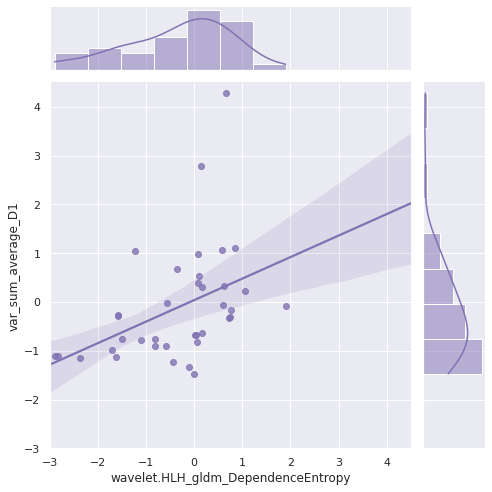

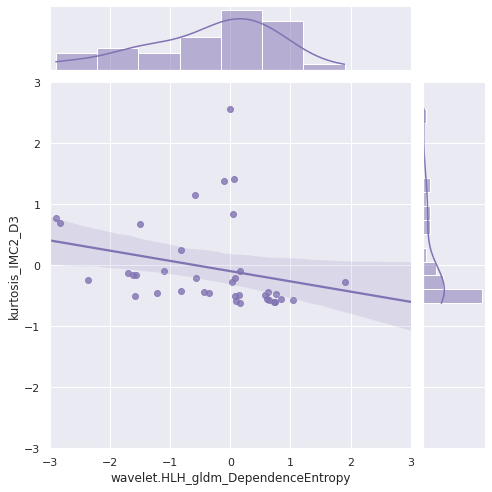

In [100]:
df = radio_pathomic_pfs_os_feature_32[['wavelet.HLH_gldm_DependenceEntropy','var_sum_average_D1', 'kurtosis_IMC2_D3']]
import seaborn as sns
sns.set_theme(style="darkgrid")

g = sns.jointplot(x="wavelet.HLH_gldm_DependenceEntropy", y="var_sum_average_D1", data=df,
                  kind="reg", truncate=False,
                  xlim=(-3, 4.5), ylim=(-3, 4.5),
                  color="m", height=7)
plt.savefig('scatter_plot1_corr_32.png', dpi=300, bbox_inches='tight')
g2 = sns.jointplot(x="wavelet.HLH_gldm_DependenceEntropy", y="kurtosis_IMC2_D3", data=df,
                  kind="reg", truncate=False,
                  xlim=(-3, 3), ylim=(-3, 3),
                  color="m", height=7)
plt.savefig('scatter_plot2_corr_32.png', dpi=300, bbox_inches='tight')

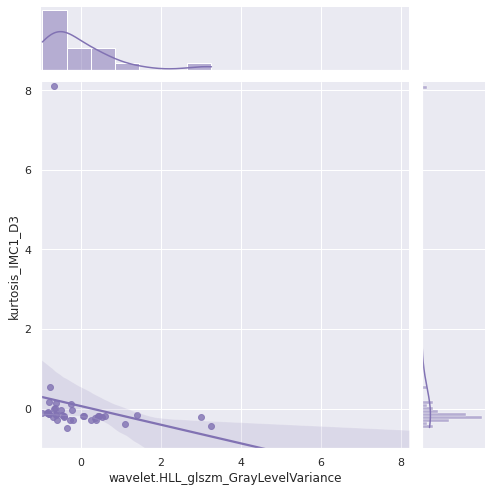

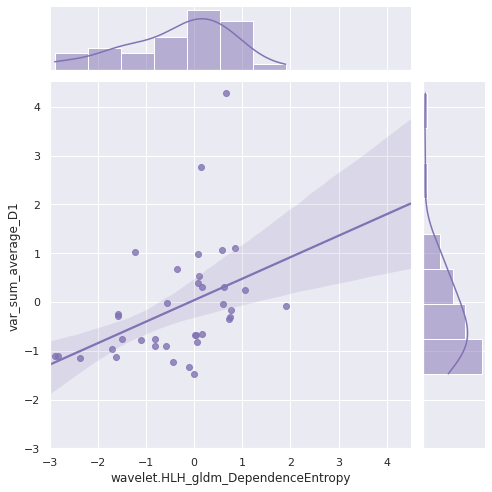

In [102]:
df = radio_pathomic_pfs_os_feature_64[['wavelet.HLH_gldm_DependenceEntropy','wavelet.HLL_glszm_GrayLevelVariance', 'kurtosis_IMC1_D3', 'var_sum_average_D1']]
import seaborn as sns
sns.set_theme(style="darkgrid")

g = sns.jointplot(x="wavelet.HLL_glszm_GrayLevelVariance", y="kurtosis_IMC1_D3", data=df,
                  kind="reg", truncate=False,
                  xlim=(-1, 8.2), ylim=(-1, 8.2),
                  color="m", height=7)
plt.savefig('scatter_plot1_corr_64.png', dpi=300, bbox_inches='tight')
g2 = sns.jointplot(x="wavelet.HLH_gldm_DependenceEntropy", y="var_sum_average_D1", data=df,
                  kind="reg", truncate=False,
                  xlim=(-3, 4.5), ylim=(-3, 4.5),
                  color="m", height=7)
plt.savefig('scatter_plot2_corr_64.png', dpi=300, bbox_inches='tight')

In [101]:
df = radio_pathomic_pfs_os_feature_64[['wavelet.HLH_gldm_DependenceEntropy','wavelet.HLL_glszm_GrayLevelVariance', 'kurtosis_IMC1_D3', 'var_sum_average_D1']]
df.describe()

,wavelet.HLH_gldm_DependenceEntropy,wavelet.HLL_glszm_GrayLevelVariance,kurtosis_IMC1_D3,var_sum_average_D1
count,37.000000,37.000000,37.000000,37.000000
mean,-0.346508,-0.053656,0.075066,-0.115091
std,1.106787,0.962835,1.370490,1.158053
min,-2.901753,-0.957820,-0.477776,-1.472446
25%,-1.107371,-0.672265,-0.214435,-0.904360
50%,0.021193,-0.410565,-0.185233,-0.312716
75%,0.572478,0.368429,-0.088591,0.312455
max,1.900307,3.263712,8.115841,4.278483


In [8]:
df = pd.read_excel('projects/def-veman3/ul-val-prj-criucpq-poc/Oncotech-WSI/Clinical_data/clinical_IHC_iucpq_chum_mai2023.xlsx')
df.describe()

,age,weight,height,bmi,ecog_status,pdl1_tps,progression,death,orr,pfs_days,pfs_months,os_days,os_months,pfs_6months,pfs_1year,pfs_2year,os_1year
count,540.000000,309.000000,309.000000,309.000000,532.000000,476.000000,540.000000,540.000000,230.000000,540.000000,540.000000,540.000000,540.000000,526.000000,513.000000,471.000000,504.000000
mean,66.779691,69.590939,165.899676,25.215220,0.874060,43.475210,0.750000,0.551852,0.426087,379.855556,12.488257,574.185185,18.877106,0.458175,0.625731,0.804671,0.359127
std,8.165218,16.815582,9.597735,5.442901,0.678652,35.374577,0.433414,0.497765,0.495585,417.391815,13.722323,442.500605,14.547807,0.498722,0.484406,0.396875,0.480221
min,39.483000,31.000000,144.000000,12.903000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.066000,2.000000,0.066000,0.000000,0.000000,0.000000,0.000000
25%,61.964000,57.600000,158.000000,21.502000,0.000000,2.375000,0.750000,0.000000,0.000000,73.500000,2.416500,216.750000,7.125750,0.000000,0.000000,1.000000,0.000000
50%,67.752500,67.300000,165.000000,24.766000,1.000000,55.000000,1.000000,1.000000,0.000000,201.500000,6.624500,492.000000,16.175000,0.000000,1.000000,1.000000,0.000000
75%,72.556250,80.000000,174.000000,28.637000,1.000000,70.000000,1.000000,1.000000,1.000000,543.250000,17.860250,841.000000,27.649000,1.000000,1.000000,1.000000,1.000000
max,88.999000,165.000000,190.000000,61.347000,3.000000,100.000000,1.000000,1.000000,1.000000,2047.000000,67.298000,2047.000000,67.298000,1.000000,1.000000,1.000000,1.000000


In [12]:
subset_CHUM_IUCPQ = pd.read_excel('projects/def-veman3/ul-val-prj-criucpq-poc/Oncotech-WSI/Clinical_data/clinical_IHC_iucpq_chum_mai2023.xlsx')
subset_CHUM_IUCPQ.rename(columns={'oncotech_id': 'wsi_name'}, inplace=True)
subset_CHUM_IUCPQ.set_index(subset_CHUM_IUCPQ.columns[0], inplace=True)


# Merge pathomic and pfs/os data
pathomic_feature_16_pfs_os = subset_CHUM_IUCPQ.join(pathomic_feature_16_reduce, how = 'inner')

# Merge radiomic feature and pfs/os data
radiomic_feature_pfs_os = radiomic_feature_reduce.join(subset_CHUM_IUCPQ, how = 'inner')

## Merge radiomic, pathomic feature and pfs/os data
radio_pathomic_pfs_os_feature_16 = pathomic_feature_16_pfs_os.join(radiomic_feature_reduce, how = 'inner')
clinical_data = radio_pathomic_pfs_os_feature_16.iloc[:, :56]

In [18]:
clinical_data.describe()

,age,weight,height,bmi,ecog_status,pdl1_tps,progression,death,orr,pfs_days,pfs_months,os_days,os_months,pfs_6months,pfs_1year,pfs_2year,os_1year
count,37.000000,24.000000,24.000000,24.000000,37.000000,37.000000,37.000000,37.000000,13.000000,37.000000,37.000000,37.000000,37.000000,36.000000,36.000000,36.000000,37.000000
mean,67.453946,69.350000,163.125000,25.772167,0.756757,33.256757,0.783784,0.513514,0.307692,475.810811,15.642919,737.783784,24.255649,0.388889,0.611111,0.750000,0.243243
std,7.237732,18.627002,10.027408,5.347552,0.641414,34.138326,0.417342,0.506712,0.480384,510.673076,16.789157,479.894325,15.777232,0.494413,0.494413,0.439155,0.434959
min,47.469000,41.000000,150.000000,16.016000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.460000,48.000000,1.578000,0.000000,0.000000,0.000000,0.000000
25%,63.179000,53.200000,154.750000,22.128250,0.000000,0.500000,1.000000,0.000000,0.000000,98.000000,3.222000,388.000000,12.756000,0.000000,0.000000,0.750000,0.000000
50%,68.301000,66.850000,161.000000,26.539500,1.000000,25.000000,1.000000,1.000000,0.000000,258.000000,8.482000,678.000000,22.290000,0.000000,1.000000,1.000000,0.000000
75%,72.334000,87.025000,168.500000,28.584500,1.000000,60.000000,1.000000,1.000000,1.000000,618.000000,20.318000,1010.000000,33.205000,1.000000,1.000000,1.000000,0.000000
max,83.168000,95.000000,187.000000,37.023000,2.000000,100.000000,1.000000,1.000000,1.000000,1888.000000,62.071000,1888.000000,62.071000,1.000000,1.000000,1.000000,1.000000


In [23]:
clinical_data.groupby('progression').size()

progression
0     8
1    29
dtype: int64

In [30]:
# Créer la nouvelle colonne basée sur les conditions
##clinical_data['os_month_cat'] = ['>12' if x > 12 else '<12' if x < 12 else '=12' for x in clinical_data['os_months']]
clinical_data['pfs_month_cat'] = ['>12' if x > 12 else '<12' if x < 12 else '=12' for x in clinical_data['pfs_months']]

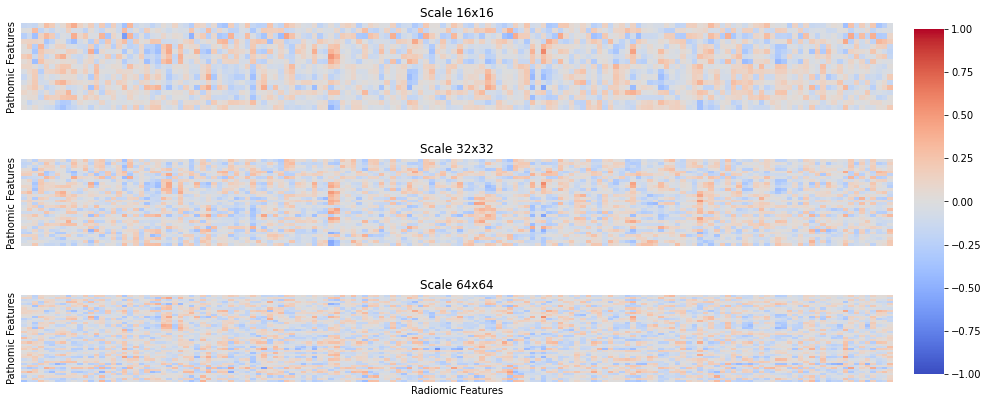

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer une figure et une grille d'axes 1x2
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 6))
# Taille de chaque carré dans les deux heatmaps
cell_size = 10
height_1 = cell_size * len(corr_matrix_16)
height_2 = cell_size * len(corr_matrix_32)
height_3 = cell_size * len(corr_matrix_64)

# Ajuster l'aspect ratio pour chaque heatmap pour qu'ils aient la même taille
aspect_1 = len(corr_matrix_16.columns) / height_1
aspect_2 = len(corr_matrix_32.columns) / height_2
aspect_3 = len(corr_matrix_64.columns) / height_3

# Utilisez le paramètre cbar_ax pour spécifier l'axe sur lequel la barre de couleur doit être dessinée
cbar_ax = fig.add_axes([.91, .1, .03, .8])  # [position_x, position_y, width, height]

# Premier heatmap
sns.heatmap(corr_matrix_16, cmap="coolwarm", vmin=-1, vmax=1, xticklabels=False, yticklabels=False, square= True,  ax=axes[0], cbar=False)
axes[0].set_title("Scale 16x16")
axes[0].set_ylabel('Pathomic Features')
axes[0].set_aspect(aspect_1)

# Deuxième heatmap
sns.heatmap(corr_matrix_32, cmap="coolwarm", vmin=-1, vmax=1, xticklabels=False, yticklabels=False, cbar_ax=cbar_ax, square= True,  ax=axes[1])
axes[1].set_title("Scale 32x32")
axes[1].set_ylabel('Pathomic Features')
axes[1].set_aspect(aspect_2)

# Troisieme heatmap
sns.heatmap(corr_matrix_64, cmap="coolwarm", vmin=-1, vmax=1, xticklabels=False, yticklabels=False, square= True, cbar=False, ax=axes[2])
axes[2].set_title("Scale 64x64")
axes[2].set_xlabel('Radiomic Features')
axes[2].set_ylabel('Pathomic Features')
axes[2].set_aspect(aspect_3)
# Ajuste l'espace entre les figures
plt.tight_layout(pad=1.5)
# Ajustez l'espace entre les figures
plt.tight_layout(rect=[0, 0, .9, 1])  # Ajustez le rect pour laisser de l'espace pour la barre de couleur

# Sauvegarder les graphiques
plt.savefig('combined_heatmaps_1_color.png', dpi=600, bbox_inches='tight')
plt.show()

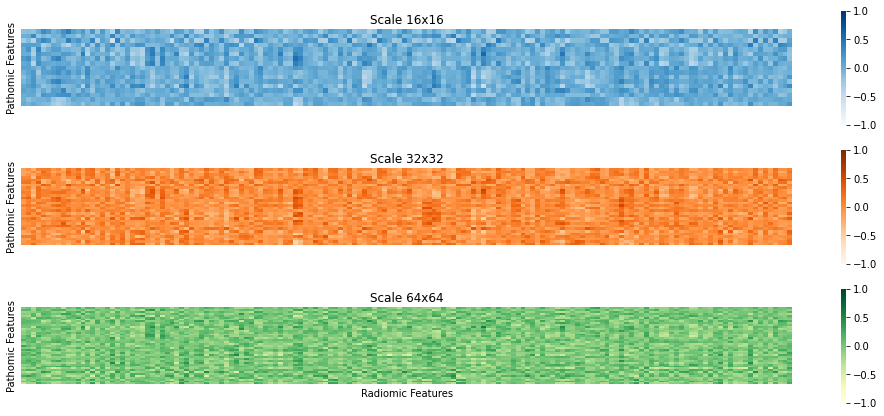

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer une figure et une grille d'axes 1x2
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 6))
# Taille de chaque carré dans les deux heatmaps
cell_size = 10
height_1 = cell_size * len(corr_matrix_16)
height_2 = cell_size * len(corr_matrix_32)
height_3 = cell_size * len(corr_matrix_64)

# Ajuster l'aspect ratio pour chaque heatmap pour qu'ils aient la même taille
aspect_1 = len(corr_matrix_16.columns) / height_1
aspect_2 = len(corr_matrix_32.columns) / height_2
aspect_3 = len(corr_matrix_64.columns) / height_3

# Utilisez le paramètre cbar_ax pour spécifier l'axe sur lequel la barre de couleur doit être dessinée
##cbar_ax = fig.add_axes([.91, .1, .03, .8])  # [position_x, position_y, width, height]

# Premier heatmap
sns.heatmap(corr_matrix_16, cmap="Blues", vmin=-1, vmax=1, xticklabels=False, yticklabels=False, square= True,  ax=axes[0], cbar=True)
axes[0].set_title("Scale 16x16")
axes[0].set_ylabel('Pathomic Features')
axes[0].set_aspect(aspect_1)

# Deuxième heatmap
sns.heatmap(corr_matrix_32, cmap="Oranges", vmin=-1, vmax=1, xticklabels=False, yticklabels=False, cbar = True, square= True,  ax=axes[1])
axes[1].set_title("Scale 32x32")
axes[1].set_ylabel('Pathomic Features')
axes[1].set_aspect(aspect_2)

# Troisieme heatmap
sns.heatmap(corr_matrix_64, cmap="YlGn", vmin=-1, vmax=1, xticklabels=False, yticklabels=False, square= True, cbar=True, ax=axes[2])
axes[2].set_title("Scale 64x64")
axes[2].set_xlabel('Radiomic Features')
axes[2].set_ylabel('Pathomic Features')
axes[2].set_aspect(aspect_3)
# Ajuste l'espace entre les figures
plt.tight_layout(pad=1.5)
# Ajustez l'espace entre les figures
##plt.tight_layout(rect=[0, 0, .9, 1])  # Ajustez le rect pour laisser de l'espace pour la barre de couleur

# Sauvegarder les graphiques
plt.savefig('combined_heatmaps_3_color.png', dpi=600, bbox_inches='tight')
plt.show()

In [16]:
positive_correlation_16 = (df_correlations_16['Correlation'] > 0).sum()
negative_correlations_16 = (df_correlations_16['Correlation'] < 0).sum()
positive_correlation_32 = (df_significant_correlations_32['Correlation'] > 0).sum()
negative_correlations_32 = (df_significant_correlations_32['Correlation'] < 0).sum()
positive_correlation_64 = (df_significant_correlations_64['Correlation'] > 0).sum()
negative_correlations_64 = (df_significant_correlations_64['Correlation'] < 0).sum()

In [31]:
import pandas as pd

pos_corr_16 = (positive_correlation_16/(positive_correlation_16+negative_correlations_16))*100
pos_corr_32 = (positive_correlation_32/(positive_correlation_32+negative_correlations_32))*100 
pos_corr_64 =  (positive_correlation_64/(positive_correlation_64+negative_correlations_64))*100
# Création des données
data = {
    'scale': ['scale 16x16', 'scale 32x32', 'scale 64x64', 'scale 16x16', 'scale 32x32', 'scale 64x64'],
    'Percentage': [pos_corr_16, pos_corr_32, pos_corr_64, 100-pos_corr_16, 100-pos_corr_32, 100-pos_corr_64],
    'Correlation': ['Positive Correlation', 'Positive Correlation', 'Positive Correlation','Negative Correlation', 'Negative Correlation', 'Negative Correlation']
}

# Construction du DataFrame
data = pd.DataFrame(data)


In [30]:
data
##print(positive_correlation_64, negative_correlations_64)

,scale,Percentage,Correlation
0,scale 16x16,0.492319,Positive Correlation
1,scale 32x32,0.466129,Positive Correlation
2,scale 64x64,0.458716,Positive Correlation
3,scale 16x16,0.507681,Negative Correlation
4,scale 32x32,0.533871,Negative Correlation
5,scale 64x64,0.541284,Negative Correlation


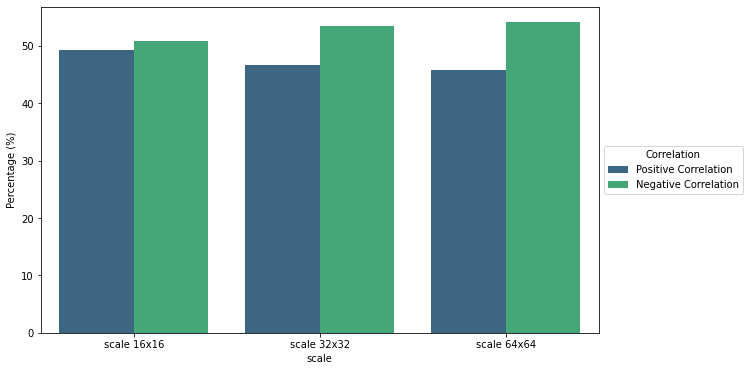

In [32]:
# Créer le barplot avec les pourcentages
plt.figure(figsize=(10,6))
sns.barplot(x='scale', y='Percentage', hue='Correlation', data=data,  palette="viridis", dodge=0.9)
plt.ylabel('Percentage (%)')
# Positionner la légende en vertical à l'extérieur du graphique
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Correlation")
plt.savefig('correlation_by_scale.png', dpi=600, bbox_inches='tight')
plt.show()

<Figure size 720x432 with 0 Axes>

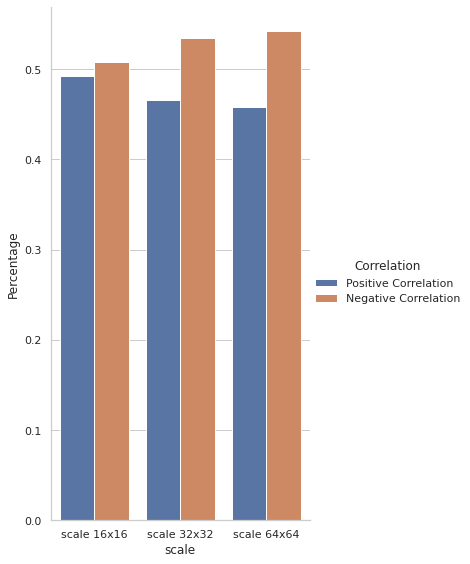

In [115]:
plt.figure(figsize=(10,6))
sns.catplot(data=data,
    x='scale', y='Percentage', hue='Correlation',
    kind="bar", height=8, aspect=.6
)

In [34]:

df_correlations_16['correlation'] = ['Positive Correlation' if x > 0 else 'Negative Correlation'  for x in df_correlations_16['Correlation']]

In [36]:
df_significant_correlations_32['correlation'] = ['Positive Correlation' if x > 0 else 'Negative Correlation'  for x in df_significant_correlations_32['Correlation']]
df_significant_correlations_64['correlation'] = ['Positive Correlation' if x > 0 else 'Negative Correlation'  for x in df_significant_correlations_64['Correlation']]

In [37]:
df_correlations_16['Scale'] = 'Scale 16x16'
df_significant_correlations_32['Scale'] = 'Scale 32x32'
df_significant_correlations_64['Scale'] = 'Scale 64x64'

In [39]:
all_data = pd.concat([df_correlations_16, df_significant_correlations_32,df_significant_correlations_64 ], ignore_index=True)

In [53]:
# Calculer les pourcentages pour chaque catégorie
total = len(all_data)
percentages = all_data.groupby(['Scale', 'correlation']).size() / total * 100
percentages = percentages.reset_index(name='Percentage')

## Radiomic feature category scale 64x64

In [14]:
df_corr = corr_matrix_64
df_corr = df_corr.reset_index()
# Fonction pour catégoriser les valeurs
def categorize_radiomic(value):
    if 'wavelet' in value:
        return "Filter-based features"
    elif any(x in value for x in ['glrlm','glcm','gldm', 'glszm', 'gldzm', 'ngtdm']):
        return "Texture-based features"
    elif 'shape' in value:
        return "Shape-based features"
    elif 'firstorder' in value:
        return "Intensity-based features"
    else:
        return "Other"

# Appliquer la fonction pour créer la nouvelle colonne
df_corr['category'] = df_corr['index'].apply(categorize_radiomic)
df_corr = df_corr.sort_values(by='category')
df_corr2 = df_corr.drop('index', axis=1)
category = df_corr2.pop("category")

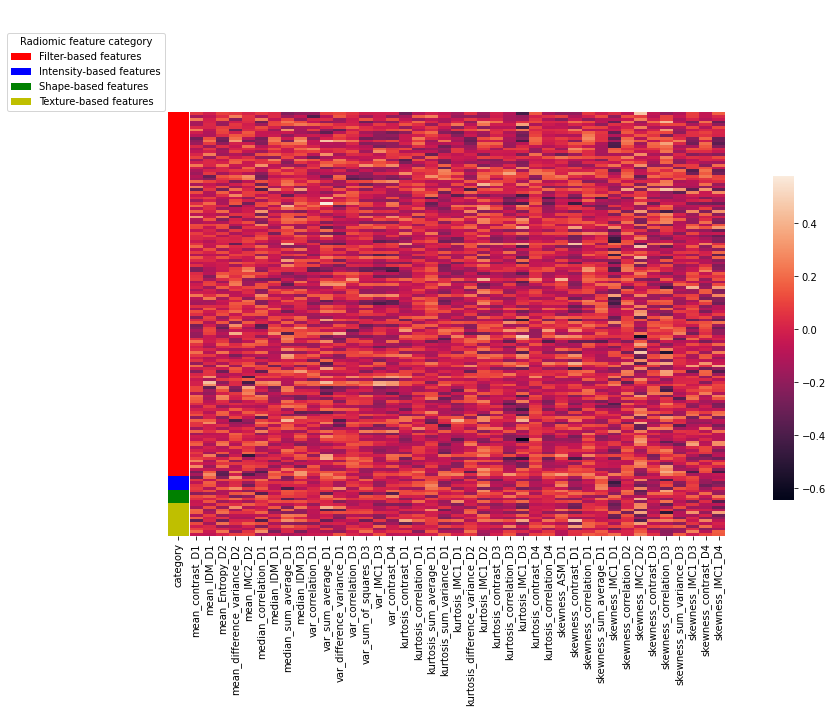

In [17]:
lut = dict(zip(category.unique(), "rbgy"))
row_colors = category.map(lut)
g = sns.clustermap(df_corr2, row_colors=row_colors, xticklabels=True, yticklabels=False, row_cluster=False, col_cluster=False)
# Changer la position de la barre de couleur
g.cax.set_position([1.05, .3, .03, .45])

# Ajouter une légende pour la catégorie
for label in category.unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="upper left", ncol=1, bbox_to_anchor=(-0.35, 0.8), title = 'Radiomic feature category' )
plt.savefig('radiopathomic.png', dpi=600, bbox_inches='tight')
plt.show()

## Radiomic feature category scale 32x32

In [13]:
# Trouver les colonnes qui sont dans df2 mais pas dans df1
# new_columns = [col for col in corr_matrix_64.columns if col not in corr_matrix_32.columns]

# # Créer un DataFrame avec ces colonnes et le même index que df1, rempli de NaN
# new_columns_df = pd.DataFrame(index=corr_matrix_32.index, columns=new_columns)

# # Concaténer ce DataFrame avec df1
# result = pd.concat([corr_matrix_32, new_columns_df], axis=1)
# df_corr32 = result
# df_corr32 = df_corr32.reset_index()
df_corr32 = corr_matrix_32
df_corr32 = df_corr32.reset_index()

# Fonction pour catégoriser les valeurs
def categorize_radiomic(value):
    if 'wavelet' in value:
        return "Filter-based features"
    elif any(x in value for x in ['glrlm','glcm','gldm', 'glszm', 'gldzm', 'ngtdm']):
        return "Texture-based features"
    elif 'shape' in value:
        return "Shape-based features"
    elif 'firstorder' in value:
        return "Intensity-based features"
    else:
        return "Other"

# Appliquer la fonction pour créer la nouvelle colonne
df_corr32['category'] = df_corr32['index'].apply(categorize_radiomic)
df_corr32 = df_corr32.sort_values(by='category')

df_corr32 = df_corr32.drop('index', axis=1)
category = df_corr32.pop("category")

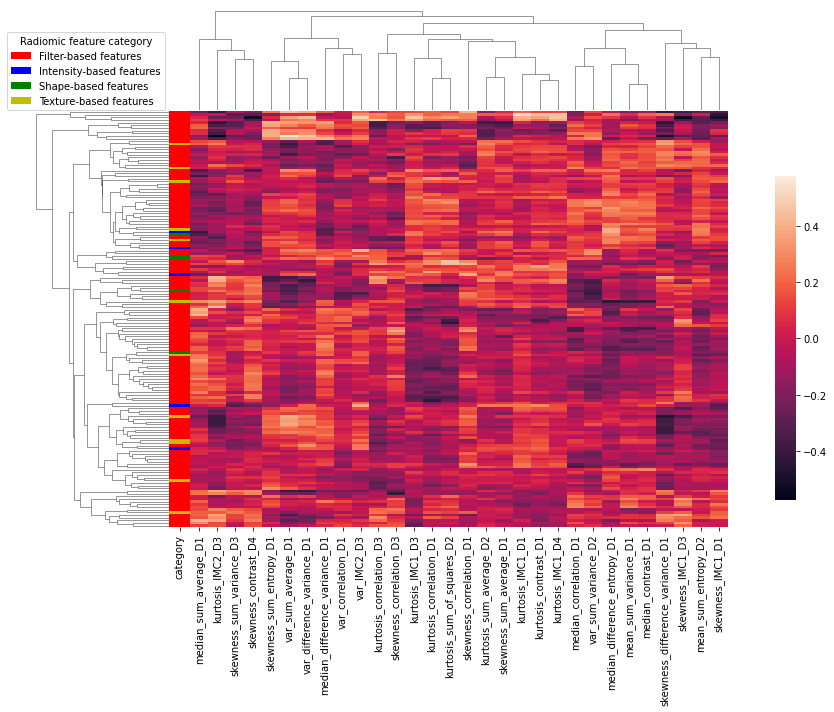

In [14]:
##mask = df_corr32.isnull()
lut = dict(zip(category.unique(), "rbgy"))
row_colors = category.map(lut)
g = sns.clustermap(df_corr32, row_colors=row_colors, xticklabels=True, yticklabels=False )
# Changer la position de la barre de couleur
g.cax.set_position([1.05, .3, .03, .45])

# Ajouter une légende pour la catégorie
for label in category.unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="upper left", ncol=1, bbox_to_anchor=(-0.35, 0.8), title = 'Radiomic feature category')
plt.savefig('radiopathomic32.png', dpi=600, bbox_inches='tight')
plt.show()

In [22]:
# Trouver les colonnes qui sont dans df2 mais pas dans df1
# new_columns = [col for col in corr_matrix_64.columns if col not in corr_matrix_32.columns]

# # Créer un DataFrame avec ces colonnes et le même index que df1, rempli de NaN
# new_columns_df = pd.DataFrame(index=corr_matrix_32.index, columns=new_columns)

# # Concaténer ce DataFrame avec df1
# result = pd.concat([corr_matrix_32, new_columns_df], axis=1)
# df_corr32 = result
# df_corr32 = df_corr32.reset_index()
df_corr16 = corr_matrix_16
df_corr16 = df_corr16.reset_index()

# Fonction pour catégoriser les valeurs
def categorize_radiomic(value):
    if 'wavelet' in value:
        return "Filter-based features"
    elif any(x in value for x in ['glrlm','glcm','gldm', 'glszm', 'gldzm', 'ngtdm']):
        return "Texture-based features"
    elif 'shape' in value:
        return "Shape-based features"
    elif 'firstorder' in value:
        return "Intensity-based features"
    else:
        return "Other"

# Appliquer la fonction pour créer la nouvelle colonne
df_corr16['category'] = df_corr16['index'].apply(categorize_radiomic)
df_corr16 = df_corr16.sort_values(by='category')

df_corr16 = df_corr16.drop('index', axis=1)
category = df_corr16.pop("category")

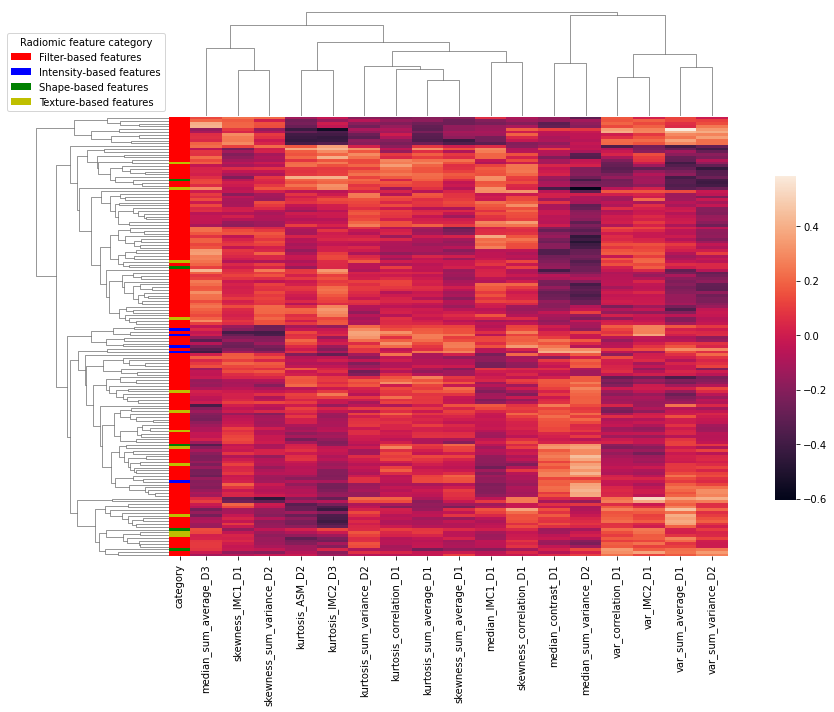

In [23]:
##mask = df_corr32.isnull()
lut = dict(zip(category.unique(), "rbgy"))
row_colors = category.map(lut)
g = sns.clustermap(df_corr16, row_colors=row_colors, xticklabels=True, yticklabels=False )
# Changer la position de la barre de couleur
g.cax.set_position([1.05, .3, .03, .45])

# Ajouter une légende pour la catégorie
for label in category.unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="upper left", ncol=1, bbox_to_anchor=(-0.35, 0.8), title = 'Radiomic feature category')
plt.savefig('radiopathomic16.png', dpi=600, bbox_inches='tight')
plt.show()